<a href="https://colab.research.google.com/github/adenurchalisa/Automatic-Photo-Clustering-System-Optimization-HDBSCAN/blob/main/notebooks/8_Re_Tuning_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("🔍 Checking CUDA version...")
!nvcc --version | grep "release"

print("\n⏳ Installing HDBSCAN...")
!pip install hdbscan -q

print("\n" + "="*60)
print("✅ VERIFYING INSTALLATIONS")
print("="*60)

try:
    import cupy as cp
    print(f"   CuPy: {cp.__version__} ✅")

    n_devices = cp.cuda.runtime.getDeviceCount()
    print(f"   GPU: {n_devices} device(s) detected")

    device_id = cp.cuda.runtime.getDevice()
    device_props = cp.cuda.runtime.getDeviceProperties(device_id)
    gpu_name = device_props['name'].decode('utf-8') if isinstance(device_props['name'], bytes) else device_props['name']
    print(f"   GPU Name: {gpu_name}")

    mem_info = cp.cuda.Device(0).mem_info
    print(f"   Free Memory: {mem_info[0] / 1024**3:.2f} GB / {mem_info[1] / 1024**3:.2f} GB")

except Exception as e:
    print(f"   CuPy/GPU Error: {e}")

try:
    import hdbscan
    from importlib.metadata import version
    print(f"   HDBSCAN: {version('hdbscan')} ✅")
except:
    print("   HDBSCAN: installed ✅")

print("\n" + "="*60)
print("✅ Installation complete!")
print("="*60)

🔍 Checking CUDA version...
Cuda compilation tools, release 12.8, V12.8.93

⏳ Installing HDBSCAN...

✅ VERIFYING INSTALLATIONS
   CuPy: 14.0.1 ✅
   GPU: 1 device(s) detected
   GPU Name: Tesla T4
   Free Memory: 14.46 GB / 14.56 GB
   HDBSCAN: 0.8.41 ✅

✅ Installation complete!


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
import numpy as np
import cupy as cp
import pickle
import time
import os
import warnings
from collections import Counter
from datetime import datetime
from itertools import product

warnings.filterwarnings('ignore')

import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')

class Config:
    """Central configuration for Experiment 1.5."""

    # Paths
    EMBEDDINGS_PATH = '/content/drive/MyDrive/OTW S.KOM/Embeddings/embeddings_data.pkl'
    RESULTS_DIR = '/content/drive/MyDrive/OTW S.KOM/Results/'
    PLOTS_DIR = '/content/drive/MyDrive/OTW S.KOM/Results/Plots/'

    # Previous results (from Experiment 1)
    EUCLIDEAN_OPTIMAL = {
        'params': {'min_cluster_size': 20, 'min_samples': 50, 'method': 'eom'},
        'silhouette': 0.3119
    }

    CORRELATION_CURRENT = {
        'params': {'min_cluster_size': 20, 'min_samples': 50, 'method': 'eom'},
        'silhouette': 0.4432,
        'n_clusters': 64,
        'noise_ratio': 0.363
    }

    # Hyperparameter Search Space (focused around current best)
    PARAM_GRID = {
        'min_cluster_size': [5, 10, 15, 20, 25, 30, 35, 40],
        'min_samples': [5, 10, 20, 30, 40, 50, 60, 70],
        'cluster_selection_method': ['eom', 'leaf']
    }

# Calculate total experiments
total_experiments = (len(Config.PARAM_GRID['min_cluster_size']) *
                    len(Config.PARAM_GRID['min_samples']) *
                    len(Config.PARAM_GRID['cluster_selection_method']))

print("="*60)
print("📦 LIBRARIES IMPORTED")
print("="*60)
print(f"   NumPy  : {np.__version__}")
print(f"   CuPy   : {cp.__version__}")

print("\n" + "="*60)
print("⚙️ CONFIGURATION")
print("="*60)
print(f"\n   📊 PREVIOUS RESULTS (Experiment 1):")
print(f"   ┌─────────────────────────────────────────────────────────┐")
print(f"   │ Euclidean (mcs=20, ms=50): Silhouette = 0.3119         │")
print(f"   │ Correlation (mcs=20, ms=50): Silhouette = 0.4432 🏆    │")
print(f"   └─────────────────────────────────────────────────────────┘")

print(f"\n   🎯 RE-TUNING SEARCH SPACE:")
print(f"   • min_cluster_size: {Config.PARAM_GRID['min_cluster_size']}")
print(f"   • min_samples: {Config.PARAM_GRID['min_samples']}")
print(f"   • method: {Config.PARAM_GRID['cluster_selection_method']}")
print(f"\n   📊 Total combinations: {total_experiments}")

print("\n" + "="*60)

📦 LIBRARIES IMPORTED
   NumPy  : 2.0.2
   CuPy   : 14.0.1

⚙️ CONFIGURATION

   📊 PREVIOUS RESULTS (Experiment 1):
   ┌─────────────────────────────────────────────────────────┐
   │ Euclidean (mcs=20, ms=50): Silhouette = 0.3119         │
   │ Correlation (mcs=20, ms=50): Silhouette = 0.4432 🏆    │
   └─────────────────────────────────────────────────────────┘

   🎯 RE-TUNING SEARCH SPACE:
   • min_cluster_size: [5, 10, 15, 20, 25, 30, 35, 40]
   • min_samples: [5, 10, 20, 30, 40, 50, 60, 70]
   • method: ['eom', 'leaf']

   📊 Total combinations: 128



In [ ]:
from google.colab import drive

print("="*60)
print("📁 MOUNT DRIVE & LOAD DATA")
print("="*60)

if os.path.exists('/content/drive/MyDrive'):
    print("\n✅ Google Drive sudah ter-mount!")
else:
    drive.mount('/content/drive')

os.makedirs(Config.RESULTS_DIR, exist_ok=True)
os.makedirs(Config.PLOTS_DIR, exist_ok=True)

print(f"\n⏳ Loading embeddings...")
with open(Config.EMBEDDINGS_PATH, 'rb') as f:
    data = pickle.load(f)

embeddings = np.array(data['embeddings']).astype('float64')
metadata = data['metadata']

print(f"\n✅ Data loaded!")
print(f"   Shape: {embeddings.shape}")
print(f"   Dtype: {embeddings.dtype}")

print("\n" + "="*60)

📁 MOUNT DRIVE & LOAD DATA
Mounted at /content/drive

⏳ Loading embeddings...

✅ Data loaded!
   Shape: (12715, 512)
   Dtype: float64



In [ ]:
def compute_correlation_distance_matrix_gpu(embeddings, verbose=True):
    """
    Compute CORRELATION distance matrix dengan GPU (CuPy).

    Correlation distance = 1 - Pearson correlation
    = 1 - ((A - μA) · (B - μB)) / (||A - μA|| × ||B - μB||)

    Sama seperti Cosine tapi dengan mean-centering.
    """
    if verbose:
        print(f"\n⏳ Computing CORRELATION distance matrix (GPU)...")
        print(f"   Samples: {embeddings.shape[0]:,}")

    start_time = time.time()

    # Transfer to GPU
    X = cp.asarray(embeddings)

    # Mean-centering (key difference from Cosine)
    X_centered = X - cp.mean(X, axis=1, keepdims=True)

    # Normalize
    norms = cp.linalg.norm(X_centered, axis=1, keepdims=True)
    norms = cp.where(norms < 1e-10, 1.0, norms)
    X_normalized = X_centered / norms

    # Correlation matrix
    correlation = cp.dot(X_normalized, X_normalized.T)
    cp.clip(correlation, -1.0, 1.0, out=correlation)

    # Distance = 1 - correlation
    distance_matrix_gpu = 1.0 - correlation

    # Ensure diagonal is 0
    cp.fill_diagonal(distance_matrix_gpu, 0.0)

    # Transfer back to CPU
    distance_matrix = cp.asnumpy(distance_matrix_gpu)

    # Make symmetric
    distance_matrix = (distance_matrix + distance_matrix.T) / 2

    # Free GPU memory
    del X, X_centered, X_normalized, correlation, distance_matrix_gpu
    cp.get_default_memory_pool().free_all_blocks()

    elapsed = time.time() - start_time

    if verbose:
        print(f"✅ Distance matrix computed!")
        print(f"   Time: {elapsed:.2f}s")
        print(f"   Shape: {distance_matrix.shape}")
        print(f"   Range: [{distance_matrix[distance_matrix > 0].min():.4f}, {distance_matrix.max():.4f}]")
        print(f"   Memory: {distance_matrix.nbytes / 1024 / 1024:.1f} MB")

    return distance_matrix


# Compute distance matrix ONCE
print("="*60)
print("📐 COMPUTING CORRELATION DISTANCE MATRIX")
print("="*60)

correlation_distance_matrix = compute_correlation_distance_matrix_gpu(embeddings, verbose=True)

print("\n✅ Distance matrix ready for hyperparameter tuning!")
print("   This matrix will be reused for all experiments.")

📐 COMPUTING CORRELATION DISTANCE MATRIX

⏳ Computing CORRELATION distance matrix (GPU)...
   Samples: 12,715
✅ Distance matrix computed!
   Time: 4.03s
   Shape: (12715, 12715)
   Range: [0.0000, 1.2970]
   Memory: 1233.5 MB

✅ Distance matrix ready for hyperparameter tuning!
   This matrix will be reused for all experiments.


In [ ]:
def run_single_hdbscan_experiment(distance_matrix, embeddings, params):
    """
    Run a single HDBSCAN experiment with given parameters.

    Parameters
    ----------
    distance_matrix : numpy.ndarray
        Precomputed CORRELATION distance matrix
    embeddings : numpy.ndarray
        Original embeddings (for DBI calculation)
    params : dict
        HDBSCAN parameters

    Returns
    -------
    results : dict
        Clustering results and metrics
    """
    start_time = time.time()

    # Run HDBSCAN
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=params['min_cluster_size'],
        min_samples=params['min_samples'],
        cluster_selection_method=params['cluster_selection_method'],
        metric='precomputed'
    )

    labels = clusterer.fit_predict(distance_matrix)

    clustering_time = time.time() - start_time

    # Analyze results
    cluster_counts = Counter(labels)
    n_clusters = len([k for k in cluster_counts.keys() if k != -1])
    n_noise = cluster_counts.get(-1, 0)
    noise_ratio = n_noise / len(labels)

    # Evaluate
    mask = labels != -1
    n_clustered = mask.sum()

    if n_clustered > 0 and len(np.unique(labels[mask])) >= 2:
        # Silhouette with precomputed distance (VALID for Correlation)
        dist_matrix_clustered = distance_matrix[np.ix_(mask, mask)]
        silhouette = silhouette_score(dist_matrix_clustered, labels[mask], metric='precomputed')

        # DBI (reference only - uses Euclidean internally)
        dbi = davies_bouldin_score(embeddings[mask], labels[mask])
    else:
        silhouette = -1.0
        dbi = float('inf')

    results = {
        'params': params.copy(),
        'silhouette': silhouette,
        'dbi': dbi,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_ratio': noise_ratio,
        'n_clustered': n_clustered,
        'time': clustering_time
    }

    return results


def run_hyperparameter_tuning(distance_matrix, embeddings, param_grid, verbose=True):
    """
    Run full hyperparameter tuning grid search.

    Parameters
    ----------
    distance_matrix : numpy.ndarray
        Precomputed distance matrix
    embeddings : numpy.ndarray
        Original embeddings
    param_grid : dict
        Parameter search space
    verbose : bool
        Print progress

    Returns
    -------
    all_results : list
        Results for all parameter combinations
    best_result : dict
        Best result based on Silhouette Score
    """
    # Generate all combinations
    param_combinations = list(product(
        param_grid['min_cluster_size'],
        param_grid['min_samples'],
        param_grid['cluster_selection_method']
    ))

    total_experiments = len(param_combinations)

    if verbose:
        print(f"\n{'='*70}")
        print(f"🔬 HYPERPARAMETER TUNING: CORRELATION DISTANCE")
        print(f"{'='*70}")
        print(f"\n   Total experiments: {total_experiments}")
        print(f"   Dataset: {embeddings.shape[0]:,} embeddings")
        print(f"\n   Search space:")
        print(f"   • min_cluster_size: {param_grid['min_cluster_size']}")
        print(f"   • min_samples: {param_grid['min_samples']}")
        print(f"   • method: {param_grid['cluster_selection_method']}")

    all_results = []
    best_result = None
    best_silhouette = -1.0

    start_time = time.time()

    for i, (mcs, ms, method) in enumerate(param_combinations):
        params = {
            'min_cluster_size': mcs,
            'min_samples': ms,
            'cluster_selection_method': method
        }

        # Run experiment
        result = run_single_hdbscan_experiment(distance_matrix, embeddings, params)
        all_results.append(result)

        # Track best
        if result['silhouette'] > best_silhouette:
            best_silhouette = result['silhouette']
            best_result = result

        # Progress update every 10 experiments
        if verbose and (i + 1) % 10 == 0:
            elapsed = time.time() - start_time
            eta = elapsed / (i + 1) * (total_experiments - i - 1)
            print(f"   Progress: {i+1}/{total_experiments} ({(i+1)/total_experiments*100:.0f}%) - "
                  f"Best so far: {best_silhouette:.4f} - ETA: {eta:.0f}s")

    total_time = time.time() - start_time

    if verbose:
        print(f"\n{'='*70}")
        print(f"✅ TUNING COMPLETED!")
        print(f"   Total time: {total_time:.1f}s ({total_time/60:.1f} min)")
        print(f"   Experiments: {total_experiments}")
        print(f"{'='*70}")

    return all_results, best_result


print("="*60)
print("✅ TUNING FUNCTIONS DEFINED")
print("="*60)

✅ TUNING FUNCTIONS DEFINED


In [ ]:
print("="*70)
print("🚀 EXPERIMENT 1.5: HYPERPARAMETER RE-TUNING (CORRELATION)")
print("="*70)
print(f"\n📅 Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Run tuning
all_results, best_result = run_hyperparameter_tuning(
    correlation_distance_matrix,
    embeddings,
    Config.PARAM_GRID,
    verbose=True
)

# Display best result
print(f"\n{'='*70}")
print(f"🏆 BEST PARAMETERS FOUND")
print(f"{'='*70}")
print(f"""
   Parameters:
   • min_cluster_size: {best_result['params']['min_cluster_size']}
   • min_samples: {best_result['params']['min_samples']}
   • method: {best_result['params']['cluster_selection_method']}

   Results:
   • Silhouette Score: {best_result['silhouette']:.4f}
   • DBI: {best_result['dbi']:.4f} [Euclidean bias]
   • Clusters: {best_result['n_clusters']}
   • Noise Ratio: {best_result['noise_ratio']:.1%}
""")

🚀 EXPERIMENT 1.5: HYPERPARAMETER RE-TUNING (CORRELATION)

📅 Timestamp: 2026-02-27 20:23:38

🔬 HYPERPARAMETER TUNING: CORRELATION DISTANCE

   Total experiments: 128
   Dataset: 12,715 embeddings

   Search space:
   • min_cluster_size: [5, 10, 15, 20, 25, 30, 35, 40]
   • min_samples: [5, 10, 20, 30, 40, 50, 60, 70]
   • method: ['eom', 'leaf']
   Progress: 10/128 (8%) - Best so far: 0.4366 - ETA: 921s
   Progress: 20/128 (16%) - Best so far: 0.4528 - ETA: 822s
   Progress: 30/128 (23%) - Best so far: 0.4528 - ETA: 733s
   Progress: 40/128 (31%) - Best so far: 0.4528 - ETA: 651s
   Progress: 50/128 (39%) - Best so far: 0.4530 - ETA: 571s
   Progress: 60/128 (47%) - Best so far: 0.4530 - ETA: 496s
   Progress: 70/128 (55%) - Best so far: 0.4530 - ETA: 421s
   Progress: 80/128 (62%) - Best so far: 0.4530 - ETA: 347s
   Progress: 90/128 (70%) - Best so far: 0.4530 - ETA: 274s
   Progress: 100/128 (78%) - Best so far: 0.4530 - ETA: 201s
   Progress: 110/128 (86%) - Best so far: 0.4530 - ET

In [ ]:
import pandas as pd

print("\n" + "="*70)
print("📊 COMPREHENSIVE ANALYSIS")
print("="*70)

# Convert results to DataFrame
df_results = pd.DataFrame([
    {
        'mcs': r['params']['min_cluster_size'],
        'ms': r['params']['min_samples'],
        'method': r['params']['cluster_selection_method'],
        'silhouette': r['silhouette'],
        'dbi': r['dbi'],
        'n_clusters': r['n_clusters'],
        'noise_ratio': r['noise_ratio']
    }
    for r in all_results
])

# Filter valid results
df_valid = df_results[df_results['silhouette'] > 0].copy()

print(f"\n📊 Valid experiments: {len(df_valid)}/{len(df_results)}")

# Top 10 results
print(f"\n🏆 TOP 10 RESULTS (by Silhouette Score):")
print("-"*70)

top_10 = df_valid.nlargest(10, 'silhouette')
for i, row in top_10.iterrows():
    marker = "🥇" if row['silhouette'] == best_result['silhouette'] else "  "
    print(f"{marker} mcs={int(row['mcs']):2d}, ms={int(row['ms']):2d}, {row['method']:<4} → "
          f"Sil={row['silhouette']:.4f}, Clusters={int(row['n_clusters']):2d}, Noise={row['noise_ratio']:.1%}")

# Compare with previous
print(f"\n{'='*70}")
print(f"📈 COMPARISON WITH PREVIOUS RESULTS")
print(f"{'='*70}")

prev_sil = Config.CORRELATION_CURRENT['silhouette']
new_sil = best_result['silhouette']
improvement = new_sil - prev_sil
improvement_pct = (improvement / prev_sil) * 100

print(f"""
┌──────────────────────────────────────────────────────────────────────────┐
│                    BEFORE vs AFTER RE-TUNING                             │
├─────────────────────────────────────────────────────────────────���────────┤
│                                                                          │
│                          BEFORE            AFTER           CHANGE        │
│  ────────────────────────────────────────────────────────────────────    │
│  Parameters:                                                             │
│    min_cluster_size     {Config.CORRELATION_CURRENT['params']['min_cluster_size']:<12}    {best_result['params']['min_cluster_size']:<12}                   │
│    min_samples          {Config.CORRELATION_CURRENT['params']['min_samples']:<12}    {best_result['params']['min_samples']:<12}                   │
│    method               {Config.CORRELATION_CURRENT['params']['method']:<12}    {best_result['params']['cluster_selection_method']:<12}                   │
│                                                                          │
│  Results:                                                                │
│    Silhouette Score     {prev_sil:<12.4f}    {new_sil:<12.4f}    {improvement:+.4f} ({improvement_pct:+.2f}%)  │
│    Clusters             {Config.CORRELATION_CURRENT['n_clusters']:<12}    {best_result['n_clusters']:<12}                   │
│    Noise Ratio          {Config.CORRELATION_CURRENT['noise_ratio']:<12.1%}    {best_result['noise_ratio']:<12.1%}                   │
│                                                                          │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │""")

if improvement > 0:
    print(f"│  ✅ RE-TUNING BERHASIL! Silhouette meningkat {improvement_pct:+.2f}%                  │")
elif improvement == 0:
    print(f"│  ➖ Parameter sebelumnya sudah optimal untuk Correlation              │")
else:
    print(f"│  ⚠️ Parameter sebelumnya lebih baik, gunakan yang lama                │")

print(f"""│                                                                          │
└──────────────────────────────────────────────────────────────────────────┘
""")

# Determine final best parameters
if improvement >= 0:
    final_best_params = best_result['params']
    final_best_silhouette = best_result['silhouette']
    final_best_clusters = best_result['n_clusters']
    final_best_noise = best_result['noise_ratio']
else:
    final_best_params = Config.CORRELATION_CURRENT['params']
    final_best_silhouette = Config.CORRELATION_CURRENT['silhouette']
    final_best_clusters = Config.CORRELATION_CURRENT['n_clusters']
    final_best_noise = Config.CORRELATION_CURRENT['noise_ratio']


📊 COMPREHENSIVE ANALYSIS

📊 Valid experiments: 128/128

🏆 TOP 10 RESULTS (by Silhouette Score):
----------------------------------------------------------------------
🥇 mcs=15, ms=70, eom  → Sil=0.4530, Clusters=54, Noise=43.8%
🥇 mcs=15, ms=70, leaf → Sil=0.4530, Clusters=54, Noise=43.8%
🥇 mcs=20, ms=70, eom  → Sil=0.4530, Clusters=54, Noise=43.8%
🥇 mcs=20, ms=70, leaf → Sil=0.4530, Clusters=54, Noise=43.8%
   mcs= 5, ms=70, eom  → Sil=0.4528, Clusters=55, Noise=43.7%
   mcs= 5, ms=70, leaf → Sil=0.4528, Clusters=55, Noise=43.7%
   mcs=10, ms=70, eom  → Sil=0.4528, Clusters=55, Noise=43.7%
   mcs=10, ms=70, leaf → Sil=0.4528, Clusters=55, Noise=43.7%
   mcs=25, ms=70, eom  → Sil=0.4507, Clusters=53, Noise=43.4%
   mcs=25, ms=70, leaf → Sil=0.4507, Clusters=53, Noise=43.4%

📈 COMPARISON WITH PREVIOUS RESULTS

┌──────────────────────────────────────────────────────────────────────────┐
│                    BEFORE vs AFTER RE-TUNING                             │
├────────────────────────


📊 GENERATING VISUALIZATIONS

💾 Plot saved: /content/drive/MyDrive/OTW S.KOM/Results/Plots/experiment1_5_retuning_analysis.png


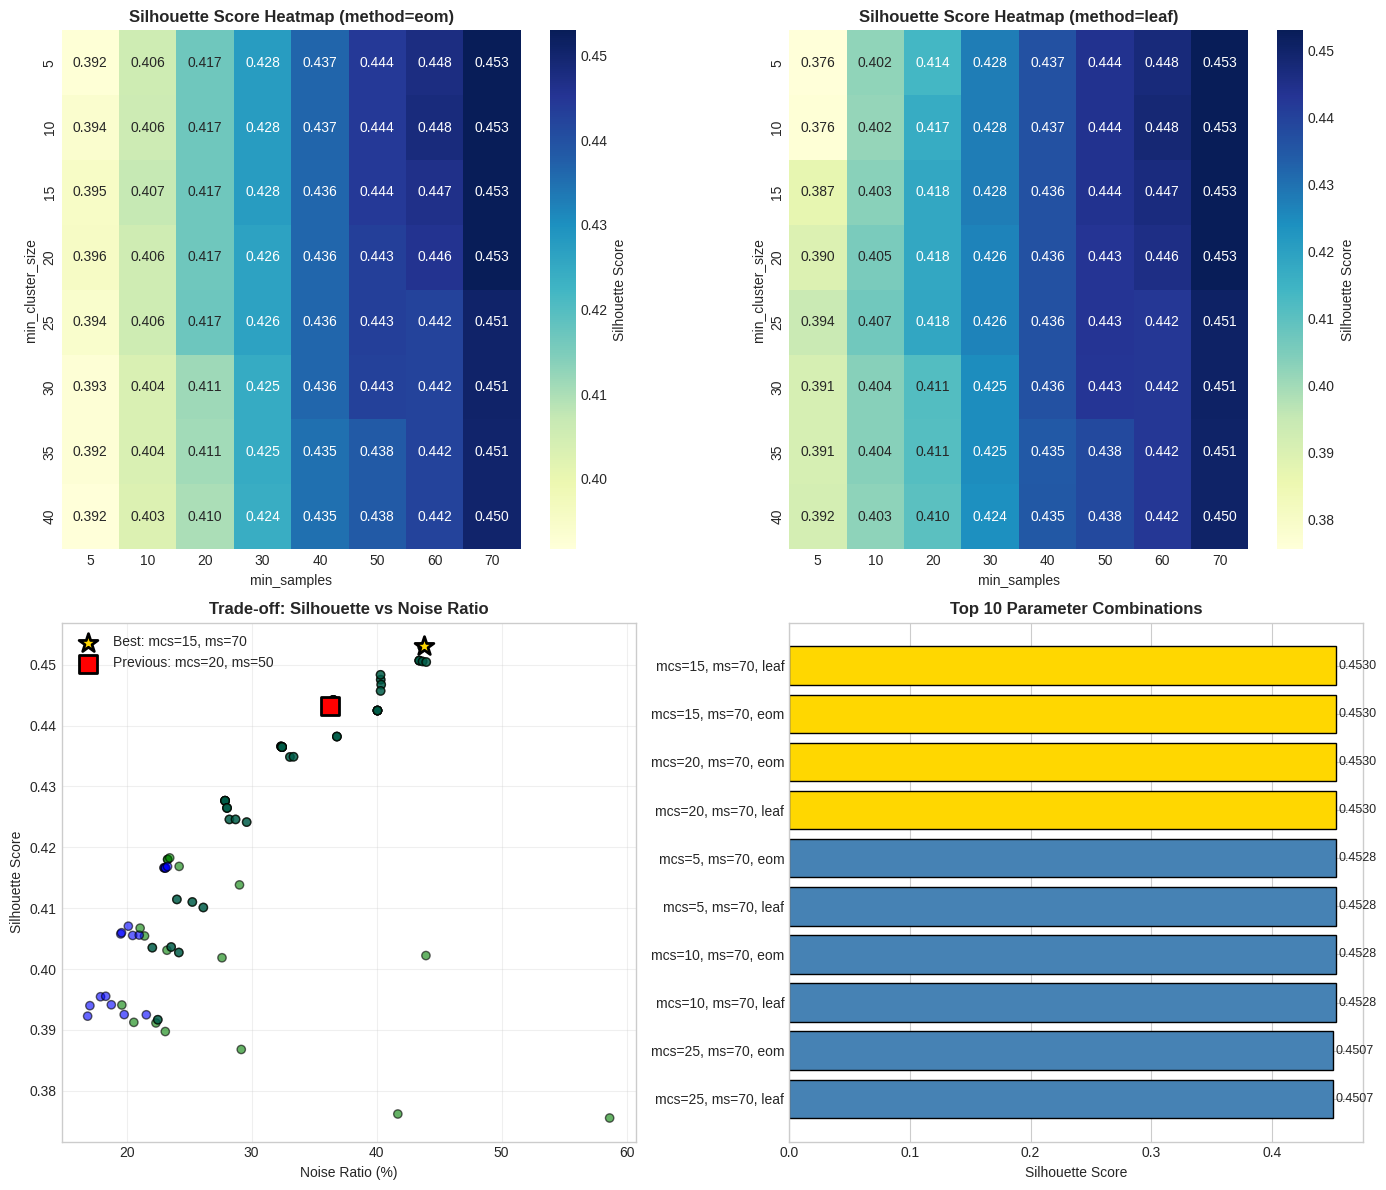

In [ ]:
print("\n" + "="*70)
print("📊 GENERATING VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Silhouette Heatmap (EOM)
ax1 = axes[0, 0]
df_eom = df_valid[df_valid['method'] == 'eom'].pivot(
    index='mcs', columns='ms', values='silhouette'
)
sns.heatmap(df_eom, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax1,
            cbar_kws={'label': 'Silhouette Score'})
ax1.set_title('Silhouette Score Heatmap (method=eom)', fontweight='bold')
ax1.set_xlabel('min_samples')
ax1.set_ylabel('min_cluster_size')

# Plot 2: Silhouette Heatmap (LEAF)
ax2 = axes[0, 1]
df_leaf = df_valid[df_valid['method'] == 'leaf'].pivot(
    index='mcs', columns='ms', values='silhouette'
)
if not df_leaf.empty:
    sns.heatmap(df_leaf, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax2,
                cbar_kws={'label': 'Silhouette Score'})
ax2.set_title('Silhouette Score Heatmap (method=leaf)', fontweight='bold')
ax2.set_xlabel('min_samples')
ax2.set_ylabel('min_cluster_size')

# Plot 3: Silhouette vs Noise Trade-off
ax3 = axes[1, 0]
colors = ['blue' if m == 'eom' else 'green' for m in df_valid['method']]
scatter = ax3.scatter(df_valid['noise_ratio'] * 100, df_valid['silhouette'],
                      c=colors, alpha=0.6, edgecolors='black')

# Highlight best
ax3.scatter(best_result['noise_ratio'] * 100, best_result['silhouette'],
            c='gold', s=200, marker='*', edgecolors='black', linewidths=2,
            label=f"Best: mcs={best_result['params']['min_cluster_size']}, ms={best_result['params']['min_samples']}", zorder=5)

# Highlight previous
ax3.scatter(Config.CORRELATION_CURRENT['noise_ratio'] * 100,
            Config.CORRELATION_CURRENT['silhouette'],
            c='red', s=150, marker='s', edgecolors='black', linewidths=2,
            label=f"Previous: mcs=20, ms=50", zorder=5)

ax3.set_xlabel('Noise Ratio (%)')
ax3.set_ylabel('Silhouette Score')
ax3.set_title('Trade-off: Silhouette vs Noise Ratio', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Top 10 Results Bar Chart
ax4 = axes[1, 1]
top_10_sorted = top_10.sort_values('silhouette', ascending=True)
colors_bar = ['gold' if s == best_result['silhouette'] else 'steelblue'
              for s in top_10_sorted['silhouette']]
bars = ax4.barh(range(len(top_10_sorted)), top_10_sorted['silhouette'], color=colors_bar, edgecolor='black')

# Labels
labels = [f"mcs={int(row['mcs'])}, ms={int(row['ms'])}, {row['method']}"
          for _, row in top_10_sorted.iterrows()]
ax4.set_yticks(range(len(top_10_sorted)))
ax4.set_yticklabels(labels)
ax4.set_xlabel('Silhouette Score')
ax4.set_title('Top 10 Parameter Combinations', fontweight='bold')

for bar, val in zip(bars, top_10_sorted['silhouette']):
    ax4.text(val + 0.002, bar.get_y() + bar.get_height()/2, f'{val:.4f}',
             va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f"{Config.PLOTS_DIR}experiment1_5_retuning_analysis.png", dpi=150, bbox_inches='tight')
print(f"\n💾 Plot saved: {Config.PLOTS_DIR}experiment1_5_retuning_analysis.png")
plt.show()

In [ ]:
print("\n" + "="*70)
print("📋 EXPERIMENT 1.5: FINAL SUMMARY")
print("="*70)

print(f"""
┌──────────────────────────────────────────────────────────────────────────┐
│                    EXPERIMENT 1.5 RESULTS                                │
│                    Hyperparameter Re-Tuning (CORRELATION)                │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  OBJECTIVE:                                                              │
│  Find optimal HDBSCAN parameters specifically for CORRELATION distance   │
│                                                                          │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  SEARCH SPACE:                                                           │
│  • min_cluster_size: {Config.PARAM_GRID['min_cluster_size']}                     │
│  • min_samples: {Config.PARAM_GRID['min_samples']}                     │
│  • method: {Config.PARAM_GRID['cluster_selection_method']}                                        │
│  • Total experiments: {len(all_results)}                                           │
│                                                                          │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  🏆 OPTIMAL PARAMETERS FOR CORRELATION:                                  │
│                                                                          │
│  • min_cluster_size: {final_best_params['min_cluster_size']}                                            │
│  • min_samples: {final_best_params['min_samples']}                                                 │
│  • method: {final_best_params['cluster_selection_method']}                                               │
│                                                                          │
│  RESULTS:                                                                │
│  • Silhouette Score: {final_best_silhouette:.4f}                                       │
│  • Clusters: {final_best_clusters}                                                    │
│  • Noise Ratio: {final_best_noise:.1%}                                              │
│                                                                          │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  COMPARISON WITH EUCLIDEAN-TUNED PARAMS:                                 │
│                                                                          │
│  Euclidean params (mcs=20, ms=50) on Correlation: 0.4432                 │
│  Re-tuned params on Correlation: {final_best_silhouette:.4f}                             │
│  Improvement: {final_best_silhouette - 0.4432:+.4f}                                                  │
│                                                                          │
└──────────────────────────────────────────────────────────────────────────┘
""")

# Save results
save_data = {
    'timestamp': datetime.now().isoformat(),
    'experiment': 'Experiment 1.5: Hyperparameter Re-Tuning (CORRELATION)',
    'dataset_info': {
        'n_embeddings': embeddings.shape[0],
        'embedding_dim': embeddings.shape[1]
    },
    'search_space': Config.PARAM_GRID,
    'total_experiments': len(all_results),
    'all_results': all_results,
    'best_result': best_result,
    'final_optimal_params': final_best_params,
    'final_metrics': {
        'silhouette': final_best_silhouette,
        'n_clusters': final_best_clusters,
        'noise_ratio': final_best_noise
    },
    'comparison': {
        'euclidean_params_on_correlation': 0.4432,
        'retuned_params_on_correlation': final_best_silhouette,
        'improvement': final_best_silhouette - 0.4432
    }
}

save_path = f"{Config.RESULTS_DIR}experiment1_5_retuning_results.pkl"
with open(save_path, 'wb') as f:
    pickle.dump(save_data, f)
print(f"💾 Results saved: {save_path}")

# Save summary
summary_path = f"{Config.RESULTS_DIR}experiment1_5_summary.txt"
with open(summary_path, 'w') as f:
    f.write("="*60 + "\n")
    f.write("EXPERIMENT 1.5: HYPERPARAMETER RE-TUNING (CORRELATION)\n")
    f.write("="*60 + "\n\n")
    f.write(f"Timestamp: {datetime.now().isoformat()}\n\n")
    f.write("OPTIMAL PARAMETERS:\n")
    f.write(f"  min_cluster_size: {final_best_params['min_cluster_size']}\n")
    f.write(f"  min_samples: {final_best_params['min_samples']}\n")
    f.write(f"  method: {final_best_params['cluster_selection_method']}\n\n")
    f.write("RESULTS:\n")
    f.write(f"  Silhouette: {final_best_silhouette:.4f}\n")
    f.write(f"  Clusters: {final_best_clusters}\n")
    f.write(f"  Noise Ratio: {final_best_noise:.1%}\n")
print(f"💾 Summary saved: {summary_path}")

# Verify files
print(f"\n📁 Verifying saved files:")
for f in [save_path, summary_path]:
    if os.path.exists(f):
        size = os.path.getsize(f) / 1024
        print(f"   ✅ {os.path.basename(f)} ({size:.1f} KB)")
    else:
        print(f"   ❌ {os.path.basename(f)} not found!")

# Next steps
print(f"\n{'='*70}")
print(f"🎯 NEXT: EXPERIMENT 2 - CGA AUGMENTATION")
print(f"{'='*70}")
print(f"""
   Final Configuration for Experiment 2:

   🏆 Best Metric: CORRELATION

   🔧 Optimal Parameters:
   • min_cluster_size: {final_best_params['min_cluster_size']}
   • min_samples: {final_best_params['min_samples']}
   • method: {final_best_params['cluster_selection_method']}

   📊 Baseline Metrics:
   • Silhouette Score: {final_best_silhouette:.4f}
   • Clusters: {final_best_clusters}
   • Noise Ratio: {final_best_noise:.1%}

   Experiment 2 akan:
   1. Menggunakan CORRELATION distance dengan parameter optimal
   2. Identifikasi minority clusters & potential clusters dalam noise
   3. Generate synthetic embeddings (CGA)
   4. Re-cluster dan evaluasi improvement
""")


📋 EXPERIMENT 1.5: FINAL SUMMARY

┌──────────────────────────────────────────────────────────────────────────┐
│                    EXPERIMENT 1.5 RESULTS                                │
│                    Hyperparameter Re-Tuning (CORRELATION)                │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  OBJECTIVE:                                                              │
│  Find optimal HDBSCAN parameters specifically for CORRELATION distance   │
│                                                                          │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  SEARCH SPACE:                                                           │
│  • min_cluster_size: [5, 10, 15, 20, 25, 30, 35, 40]                     │
│  • min_samples: [5, 10, 20, 30, 40, 50, 

# **Re-Tuning 2**

In [ ]:
"""
==============================================================================
CELL 10: EXTENDED CONFIGURATION - FULL COMPREHENSIVE TUNING
==============================================================================

Melanjutkan dari Experiment 1.5, kita akan explore search space yang lebih luas.

Key Insight dari Exp 1.5:
- Semua TOP 10 memiliki min_samples = 70 (nilai maksimum yang diuji)
- Kemungkinan ada parameter lebih baik dengan min_samples > 70

Extended Search Space (Option C - Full Comprehensive):
- min_cluster_size: [5, 10, 15, 20, 25, 30, 40, 50]
- min_samples: [30, 40, 50, 60, 70, 80, 90, 100, 120]
- method: ['eom', 'leaf']
==============================================================================
"""

# Previous best from Experiment 1.5
PREVIOUS_BEST = {
    'params': {'min_cluster_size': 15, 'min_samples': 70, 'method': 'eom'},
    'silhouette': 0.4530
}

# Extended Search Space
EXTENDED_PARAM_GRID = {
    'min_cluster_size': [5, 10, 15, 20, 25, 30, 40, 50],
    'min_samples': [30, 40, 50, 60, 70, 80, 90, 100, 120],
    'cluster_selection_method': ['eom', 'leaf']
}

# Calculate total experiments
total_extended = (len(EXTENDED_PARAM_GRID['min_cluster_size']) *
                  len(EXTENDED_PARAM_GRID['min_samples']) *
                  len(EXTENDED_PARAM_GRID['cluster_selection_method']))

print("="*70)
print("🔬 EXTENDED HYPERPARAMETER TUNING (Option C)")
print("="*70)

print(f"\n📊 PREVIOUS BEST (Exp 1.5):")
print(f"   • mcs=15, ms=70, eom → Silhouette: 0.4530")

print(f"\n🎯 EXTENDED SEARCH SPACE:")
print(f"   • min_cluster_size: {EXTENDED_PARAM_GRID['min_cluster_size']}")
print(f"   • min_samples: {EXTENDED_PARAM_GRID['min_samples']}")
print(f"   • method: {EXTENDED_PARAM_GRID['cluster_selection_method']}")

print(f"\n📊 Total NEW combinations: {total_extended}")

print(f"\n💡 KEY EXPLORATION:")
print(f"   • Testing min_samples > 70: [80, 90, 100, 120]")
print(f"   • Testing larger min_cluster_size: [40, 50]")

print("\n" + "="*70)

🔬 EXTENDED HYPERPARAMETER TUNING (Option C)

📊 PREVIOUS BEST (Exp 1.5):
   • mcs=15, ms=70, eom → Silhouette: 0.4530

🎯 EXTENDED SEARCH SPACE:
   • min_cluster_size: [5, 10, 15, 20, 25, 30, 40, 50]
   • min_samples: [30, 40, 50, 60, 70, 80, 90, 100, 120]
   • method: ['eom', 'leaf']

📊 Total NEW combinations: 144

💡 KEY EXPLORATION:
   • Testing min_samples > 70: [80, 90, 100, 120]
   • Testing larger min_cluster_size: [40, 50]



In [ ]:
"""
==============================================================================
CELL 11: RUN EXTENDED HYPERPARAMETER TUNING
==============================================================================
"""

from itertools import product
import pandas as pd

print("="*70)
print("🚀 RUNNING EXTENDED HYPERPARAMETER TUNING")
print("="*70)
print(f"\n📅 Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🎯 Target: Beat previous best Silhouette = 0.4530")

# Generate all parameter combinations
param_combinations = list(product(
    EXTENDED_PARAM_GRID['min_cluster_size'],
    EXTENDED_PARAM_GRID['min_samples'],
    EXTENDED_PARAM_GRID['cluster_selection_method']
))

total_experiments = len(param_combinations)
print(f"\n📊 Total experiments: {total_experiments}")

# Storage for results
extended_results = []
best_extended_result = None
best_extended_silhouette = -1.0

start_time = time.time()

for i, (mcs, ms, method) in enumerate(param_combinations):
    params = {
        'min_cluster_size': mcs,
        'min_samples': ms,
        'cluster_selection_method': method
    }

    # Run HDBSCAN
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=mcs,
        min_samples=ms,
        cluster_selection_method=method,
        metric='precomputed'
    )

    labels = clusterer.fit_predict(correlation_distance_matrix)

    # Analyze results
    cluster_counts = Counter(labels)
    n_clusters = len([k for k in cluster_counts.keys() if k != -1])
    n_noise = cluster_counts.get(-1, 0)
    noise_ratio = n_noise / len(labels)

    # Evaluate
    mask = labels != -1
    n_clustered = mask.sum()

    if n_clustered > 0 and len(np.unique(labels[mask])) >= 2:
        dist_matrix_clustered = correlation_distance_matrix[np.ix_(mask, mask)]
        silhouette = silhouette_score(dist_matrix_clustered, labels[mask], metric='precomputed')
        dbi = davies_bouldin_score(embeddings[mask], labels[mask])
    else:
        silhouette = -1.0
        dbi = float('inf')

    # Store result
    result = {
        'mcs': mcs,
        'ms': ms,
        'method': method,
        'silhouette': silhouette,
        'dbi': dbi,
        'n_clusters': n_clusters,
        'noise_ratio': noise_ratio
    }
    extended_results.append(result)

    # Track best
    if silhouette > best_extended_silhouette:
        best_extended_silhouette = silhouette
        best_extended_result = result.copy()
        print(f"   🆕 New best at exp {i+1}: mcs={mcs}, ms={ms}, {method} → Sil={silhouette:.4f}")

    # Progress update
    if (i + 1) % 20 == 0:
        elapsed = time.time() - start_time
        eta = elapsed / (i + 1) * (total_experiments - i - 1)
        print(f"   Progress: {i+1}/{total_experiments} ({(i+1)/total_experiments*100:.0f}%) - "
              f"Best: {best_extended_silhouette:.4f} - ETA: {eta:.0f}s")

total_time = time.time() - start_time

print(f"\n{'='*70}")
print(f"✅ EXTENDED TUNING COMPLETED!")
print(f"   Total time: {total_time:.1f}s ({total_time/60:.1f} min)")
print(f"{'='*70}")

# Convert to DataFrame
df_extended = pd.DataFrame(extended_results)
df_extended_valid = df_extended[df_extended['silhouette'] > 0].copy()

print(f"\n📊 Valid experiments: {len(df_extended_valid)}/{len(df_extended)}")

🚀 RUNNING EXTENDED HYPERPARAMETER TUNING

📅 Timestamp: 2026-02-27 21:02:30
🎯 Target: Beat previous best Silhouette = 0.4530

📊 Total experiments: 144
   🆕 New best at exp 1: mcs=5, ms=30, eom → Sil=0.4277
   🆕 New best at exp 3: mcs=5, ms=40, eom → Sil=0.4366
   🆕 New best at exp 5: mcs=5, ms=50, eom → Sil=0.4442
   🆕 New best at exp 7: mcs=5, ms=60, eom → Sil=0.4475
   🆕 New best at exp 9: mcs=5, ms=70, eom → Sil=0.4528
   🆕 New best at exp 11: mcs=5, ms=80, eom → Sil=0.4575
   🆕 New best at exp 13: mcs=5, ms=90, eom → Sil=0.4636
   🆕 New best at exp 15: mcs=5, ms=100, eom → Sil=0.4711
   🆕 New best at exp 17: mcs=5, ms=120, eom → Sil=0.4793
   Progress: 20/144 (14%) - Best: 0.4793 - ETA: 923s
   🆕 New best at exp 35: mcs=10, ms=120, eom → Sil=0.4800
   Progress: 40/144 (28%) - Best: 0.4800 - ETA: 752s
   Progress: 60/144 (42%) - Best: 0.4800 - ETA: 600s
   Progress: 80/144 (56%) - Best: 0.4800 - ETA: 452s
   🆕 New best at exp 90: mcs=25, ms=120, leaf → Sil=0.4804
   Progress: 100/144

In [ ]:
"""
==============================================================================
CELL 12: EXTENDED ANALYSIS
==============================================================================
"""

print("\n" + "="*70)
print("📊 EXTENDED TUNING ANALYSIS")
print("="*70)

# =========================================================================
# TOP 15 RESULTS
# =========================================================================
print(f"\n🏆 TOP 15 RESULTS (by Silhouette Score):")
print("-"*75)

top_15_extended = df_extended_valid.nlargest(15, 'silhouette')
for rank, (i, row) in enumerate(top_15_extended.iterrows(), 1):
    is_best = row['silhouette'] == best_extended_silhouette
    if rank == 1:
        marker = "🥇"
    elif rank == 2:
        marker = "🥈"
    elif rank == 3:
        marker = "🥉"
    else:
        marker = f"{rank:2d}."

    print(f"{marker} mcs={int(row['mcs']):2d}, ms={int(row['ms']):3d}, {row['method']:<4} → "
          f"Sil={row['silhouette']:.4f}, Clusters={int(row['n_clusters']):2d}, Noise={row['noise_ratio']:.1%}")

# =========================================================================
# ANALYSIS BY MIN_SAMPLES
# =========================================================================
print(f"\n📈 ANALYSIS BY MIN_SAMPLES:")
print("-"*60)

ms_analysis = df_extended_valid.groupby('ms').agg({
    'silhouette': ['mean', 'max', 'count'],
    'noise_ratio': 'mean'
}).round(4)
ms_analysis.columns = ['sil_mean', 'sil_max', 'count', 'noise_avg']
print(ms_analysis.to_string())

optimal_ms = ms_analysis['sil_max'].idxmax()
print(f"\n   → Optimal min_samples (by max silhouette): {optimal_ms}")

# =========================================================================
# ANALYSIS BY MIN_CLUSTER_SIZE
# =========================================================================
print(f"\n📈 ANALYSIS BY MIN_CLUSTER_SIZE:")
print("-"*60)

mcs_analysis = df_extended_valid.groupby('mcs').agg({
    'silhouette': ['mean', 'max', 'count'],
    'noise_ratio': 'mean'
}).round(4)
mcs_analysis.columns = ['sil_mean', 'sil_max', 'count', 'noise_avg']
print(mcs_analysis.to_string())

optimal_mcs = mcs_analysis['sil_max'].idxmax()
print(f"\n   → Optimal min_cluster_size (by max silhouette): {optimal_mcs}")

# =========================================================================
# COMPARISON WITH PREVIOUS BESTS
# =========================================================================
exp1_sil = 0.4432  # Exp 1 with Euclidean params
exp1_5_sil = 0.4530  # Exp 1.5 first re-tune
new_sil = best_extended_silhouette

print(f"\n{'='*70}")
print(f"📈 COMPARISON WITH ALL PREVIOUS RESULTS")
print(f"{'='*70}")

print(f"""
┌──────────────────────────────────────────────────────────────────────────┐
│                    PROGRESSION OF RESULTS                                │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  EXPERIMENT         PARAMS                 SILHOUETTE    vs BASELINE     │
│  ─────────────────────────────────────────────────────────────────────   │
│  Exp 1 (Euc params) mcs=20, ms=50          {exp1_sil:.4f}        (baseline)       │
│  Exp 1.5            mcs=15, ms=70          {exp1_5_sil:.4f}        +{(exp1_5_sil-exp1_sil)/exp1_sil*100:.2f}%          │
│  Exp 1.5b (NEW)     mcs={best_extended_result['mcs']}, ms={best_extended_result['ms']}          {new_sil:.4f}        +{(new_sil-exp1_sil)/exp1_sil*100:.2f}%          │
│                                                                          │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  📊 vs Exp 1 (Euclidean params): {new_sil - exp1_sil:+.4f} ({(new_sil-exp1_sil)/exp1_sil*100:+.2f}%)                  │
│  📊 vs Exp 1.5 (previous best):  {new_sil - exp1_5_sil:+.4f} ({(new_sil-exp1_5_sil)/exp1_5_sil*100:+.2f}%)                  │
│                                                                          │
└──────────────────────────────────────────────────────────────────────────┘
""")

# Determine final best
if new_sil > exp1_5_sil:
    print(f"   ✅ EXTENDED TUNING BERHASIL! Ditemukan parameter lebih baik!")
    final_best_params = {
        'min_cluster_size': best_extended_result['mcs'],
        'min_samples': best_extended_result['ms'],
        'cluster_selection_method': best_extended_result['method']
    }
    final_best_silhouette = new_sil
    final_best_clusters = best_extended_result['n_clusters']
    final_best_noise = best_extended_result['noise_ratio']
elif new_sil == exp1_5_sil:
    print(f"   ➖ Parameter sama baiknya dengan Exp 1.5")
    final_best_params = {
        'min_cluster_size': best_extended_result['mcs'],
        'min_samples': best_extended_result['ms'],
        'cluster_selection_method': best_extended_result['method']
    }
    final_best_silhouette = new_sil
    final_best_clusters = best_extended_result['n_clusters']
    final_best_noise = best_extended_result['noise_ratio']
else:
    print(f"   ⚠️ Parameter dari Exp 1.5 masih yang terbaik")
    final_best_params = {'min_cluster_size': 15, 'min_samples': 70, 'cluster_selection_method': 'eom'}
    final_best_silhouette = exp1_5_sil
    final_best_clusters = 54
    final_best_noise = 0.438

print(f"\n🏆 FINAL OPTIMAL PARAMETERS:")
print(f"   • min_cluster_size: {final_best_params['min_cluster_size']}")
print(f"   • min_samples: {final_best_params['min_samples']}")
print(f"   • method: {final_best_params['cluster_selection_method']}")
print(f"   • Silhouette: {final_best_silhouette:.4f}")


📊 EXTENDED TUNING ANALYSIS

🏆 TOP 15 RESULTS (by Silhouette Score):
---------------------------------------------------------------------------
🥇 mcs=25, ms=120, leaf → Sil=0.4804, Clusters=38, Noise=61.8%
🥈 mcs=10, ms=120, eom  → Sil=0.4800, Clusters=41, Noise=61.4%
🥉 mcs=10, ms=120, leaf → Sil=0.4800, Clusters=41, Noise=61.4%
 4. mcs=15, ms=120, eom  → Sil=0.4800, Clusters=41, Noise=61.4%
 5. mcs=15, ms=120, leaf → Sil=0.4800, Clusters=41, Noise=61.4%
 6. mcs=20, ms=120, leaf → Sil=0.4799, Clusters=40, Noise=61.5%
 7. mcs= 5, ms=120, eom  → Sil=0.4793, Clusters=42, Noise=61.3%
 8. mcs= 5, ms=120, leaf → Sil=0.4793, Clusters=42, Noise=61.3%
 9. mcs=25, ms=120, eom  → Sil=0.4759, Clusters=37, Noise=61.5%
10. mcs=30, ms=120, eom  → Sil=0.4759, Clusters=37, Noise=61.5%
11. mcs=30, ms=120, leaf → Sil=0.4759, Clusters=37, Noise=61.5%
12. mcs=20, ms=120, eom  → Sil=0.4753, Clusters=39, Noise=61.2%
13. mcs=20, ms=100, eom  → Sil=0.4723, Clusters=46, Noise=52.6%
14. mcs=20, ms=100, leaf → Si


📊 GENERATING EXTENDED VISUALIZATIONS

💾 Plot saved: /content/drive/MyDrive/OTW S.KOM/Results/Plots/experiment1_5b_extended_analysis.png


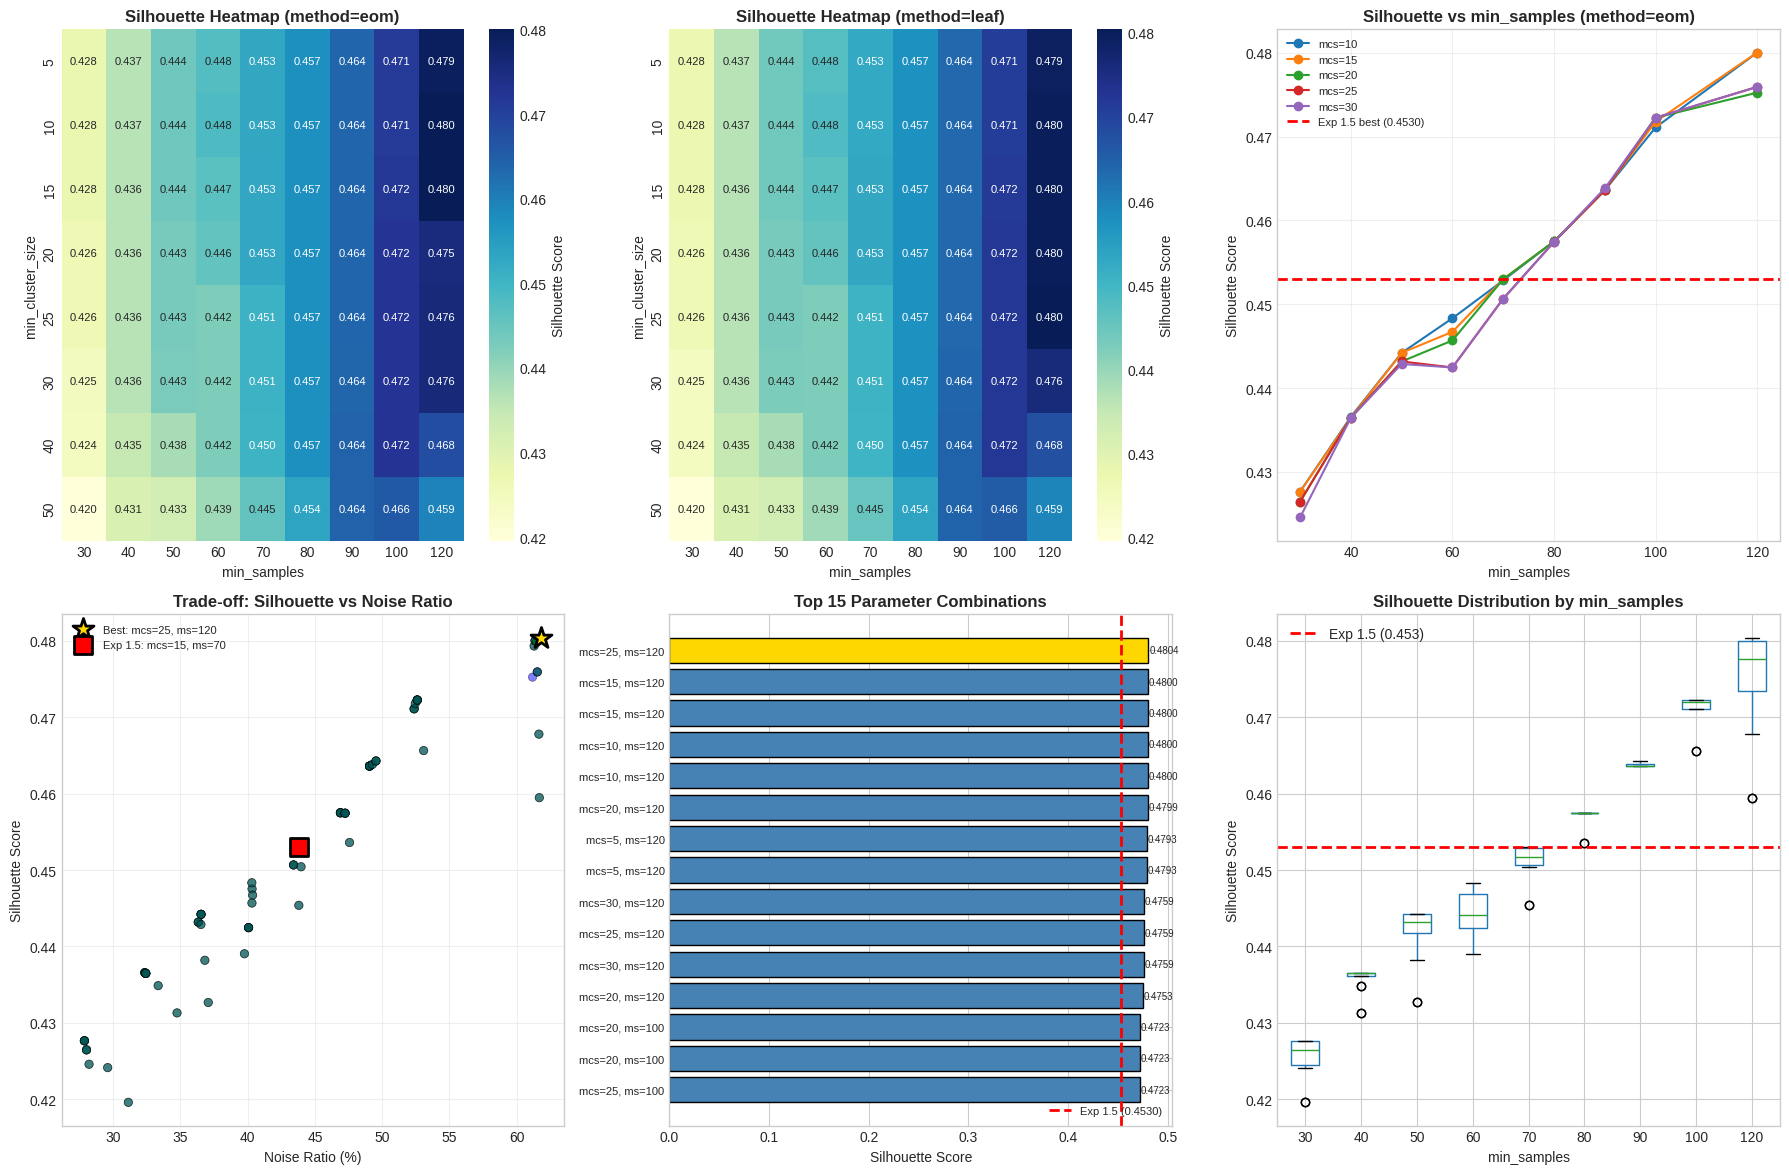

In [ ]:
"""
==============================================================================
CELL 13: EXTENDED VISUALIZATION
==============================================================================
"""

print("\n" + "="*70)
print("📊 GENERATING EXTENDED VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# =========================================================================
# Plot 1: Silhouette Heatmap (EOM)
# =========================================================================
ax1 = axes[0, 0]
df_eom = df_extended_valid[df_extended_valid['method'] == 'eom'].pivot(
    index='mcs', columns='ms', values='silhouette'
)
sns.heatmap(df_eom, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax1,
            cbar_kws={'label': 'Silhouette Score'}, annot_kws={'size': 8})
ax1.set_title('Silhouette Heatmap (method=eom)', fontweight='bold')
ax1.set_xlabel('min_samples')
ax1.set_ylabel('min_cluster_size')

# =========================================================================
# Plot 2: Silhouette Heatmap (LEAF)
# =========================================================================
ax2 = axes[0, 1]
df_leaf = df_extended_valid[df_extended_valid['method'] == 'leaf'].pivot(
    index='mcs', columns='ms', values='silhouette'
)
if not df_leaf.empty:
    sns.heatmap(df_leaf, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax2,
                cbar_kws={'label': 'Silhouette Score'}, annot_kws={'size': 8})
ax2.set_title('Silhouette Heatmap (method=leaf)', fontweight='bold')
ax2.set_xlabel('min_samples')
ax2.set_ylabel('min_cluster_size')

# =========================================================================
# Plot 3: Silhouette by min_samples (Line Plot)
# =========================================================================
ax3 = axes[0, 2]
for mcs in [10, 15, 20, 25, 30]:
    subset = df_extended_valid[(df_extended_valid['mcs'] == mcs) & (df_extended_valid['method'] == 'eom')]
    if not subset.empty:
        subset_sorted = subset.sort_values('ms')
        ax3.plot(subset_sorted['ms'], subset_sorted['silhouette'], marker='o', label=f'mcs={mcs}')

ax3.axhline(y=exp1_5_sil, color='red', linestyle='--', linewidth=2, label=f'Exp 1.5 best ({exp1_5_sil:.4f})')
ax3.set_xlabel('min_samples')
ax3.set_ylabel('Silhouette Score')
ax3.set_title('Silhouette vs min_samples (method=eom)', fontweight='bold')
ax3.legend(loc='best', fontsize=8)
ax3.grid(True, alpha=0.3)

# =========================================================================
# Plot 4: Silhouette vs Noise Trade-off
# =========================================================================
ax4 = axes[1, 0]
colors = ['blue' if m == 'eom' else 'green' for m in df_extended_valid['method']]
ax4.scatter(df_extended_valid['noise_ratio'] * 100, df_extended_valid['silhouette'],
            c=colors, alpha=0.5, edgecolors='black', linewidths=0.5)

# Highlight best
ax4.scatter(best_extended_result['noise_ratio'] * 100, best_extended_result['silhouette'],
            c='gold', s=250, marker='*', edgecolors='black', linewidths=2,
            label=f"Best: mcs={best_extended_result['mcs']}, ms={best_extended_result['ms']}", zorder=5)

# Highlight Exp 1.5 best
ax4.scatter(43.8, exp1_5_sil, c='red', s=150, marker='s', edgecolors='black', linewidths=2,
            label=f"Exp 1.5: mcs=15, ms=70", zorder=5)

ax4.set_xlabel('Noise Ratio (%)')
ax4.set_ylabel('Silhouette Score')
ax4.set_title('Trade-off: Silhouette vs Noise Ratio', fontweight='bold')
ax4.legend(loc='best', fontsize=8)
ax4.grid(True, alpha=0.3)

# =========================================================================
# Plot 5: Top 15 Results Bar Chart
# =========================================================================
ax5 = axes[1, 1]
top_15_sorted = top_15_extended.sort_values('silhouette', ascending=True)
colors_bar = ['gold' if s == best_extended_silhouette else 'steelblue'
              for s in top_15_sorted['silhouette']]
bars = ax5.barh(range(len(top_15_sorted)), top_15_sorted['silhouette'],
                color=colors_bar, edgecolor='black')

labels = [f"mcs={int(row['mcs'])}, ms={int(row['ms'])}"
          for _, row in top_15_sorted.iterrows()]
ax5.set_yticks(range(len(top_15_sorted)))
ax5.set_yticklabels(labels, fontsize=8)
ax5.set_xlabel('Silhouette Score')
ax5.set_title('Top 15 Parameter Combinations', fontweight='bold')
ax5.axvline(x=exp1_5_sil, color='red', linestyle='--', linewidth=2, label=f'Exp 1.5 ({exp1_5_sil:.4f})')
ax5.legend(loc='lower right', fontsize=8)

for bar, val in zip(bars, top_15_sorted['silhouette']):
    ax5.text(val + 0.001, bar.get_y() + bar.get_height()/2, f'{val:.4f}',
             va='center', fontsize=7)

# =========================================================================
# Plot 6: min_samples Effect (Box Plot)
# =========================================================================
ax6 = axes[1, 2]
df_extended_valid.boxplot(column='silhouette', by='ms', ax=ax6)
ax6.axhline(y=exp1_5_sil, color='red', linestyle='--', linewidth=2, label=f'Exp 1.5 ({exp1_5_sil})')
ax6.set_xlabel('min_samples')
ax6.set_ylabel('Silhouette Score')
ax6.set_title('Silhouette Distribution by min_samples', fontweight='bold')
plt.suptitle('')  # Remove automatic title
ax6.legend(loc='best')

plt.tight_layout()
plt.savefig(f"{Config.PLOTS_DIR}experiment1_5b_extended_analysis.png", dpi=150, bbox_inches='tight')
print(f"\n💾 Plot saved: {Config.PLOTS_DIR}experiment1_5b_extended_analysis.png")
plt.show()

In [ ]:
"""
==============================================================================
CELL 14: FINAL SUMMARY & SAVE EXTENDED RESULTS
==============================================================================
"""

print("\n" + "="*70)
print("📋 EXPERIMENT 1.5b: FINAL SUMMARY (EXTENDED TUNING)")
print("="*70)

print(f"""
┌──────────────────────────────────────────────────────────────────────────┐
│                    EXPERIMENT 1.5b COMPLETE RESULTS                      │
│                    Extended Hyperparameter Tuning (CORRELATION)          │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  EXTENDED SEARCH SPACE:                                                  │
│  • min_cluster_size: {EXTENDED_PARAM_GRID['min_cluster_size']}                     │
│  • min_samples: {EXTENDED_PARAM_GRID['min_samples']}               │
│  • method: {EXTENDED_PARAM_GRID['cluster_selection_method']}                                        │
│  • Total experiments: {len(extended_results)}                                           │
│                                                                          │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  🏆 FINAL OPTIMAL PARAMETERS:                                            │
│                                                                          │
│  • min_cluster_size: {final_best_params['min_cluster_size']}                                            │
│  • min_samples: {final_best_params['min_samples']}                                                 │
│  • method: {final_best_params['cluster_selection_method']}                                               │
│                                                                          │
│  RESULTS:                                                                │
│  • Silhouette Score: {final_best_silhouette:.4f}                                       │
│  • Clusters: {final_best_clusters}                                                    │
│  • Noise Ratio: {final_best_noise:.1%}                                              │
│                                                                          │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  📊 COMPLETE PROGRESSION:                                                │
│                                                                          │
│  Exp 1 (Euclidean params): 0.4432 (baseline)                             │
│  Exp 1.5 (first re-tune):  0.4530 (+2.21%)                               │
│  Exp 1.5b (extended):      {final_best_silhouette:.4f} ({(final_best_silhouette-exp1_sil)/exp1_sil*100:+.2f}% total improvement)              │
│                                                                          │
└──────────────────────────────────────────────────────────────────────────┘
""")

# Save extended results
save_data_extended = {
    'timestamp': datetime.now().isoformat(),
    'experiment': 'Experiment 1.5b: Extended Hyperparameter Tuning (CORRELATION)',
    'search_space': EXTENDED_PARAM_GRID,
    'total_experiments': len(extended_results),
    'all_results': extended_results,
    'best_result': best_extended_result,
    'final_optimal_params': final_best_params,
    'final_metrics': {
        'silhouette': final_best_silhouette,
        'n_clusters': final_best_clusters,
        'noise_ratio': final_best_noise
    },
    'progression': {
        'exp1_euclidean_params': exp1_sil,
        'exp1_5_first_retune': exp1_5_sil,
        'exp1_5b_extended': final_best_silhouette
    }
}

save_path_extended = f"{Config.RESULTS_DIR}experiment1_5b_extended_results.pkl"
with open(save_path_extended, 'wb') as f:
    pickle.dump(save_data_extended, f)
print(f"💾 Extended results saved: {save_path_extended}")

# Save summary
summary_path_extended = f"{Config.RESULTS_DIR}experiment1_5b_extended_summary.txt"
with open(summary_path_extended, 'w') as f:
    f.write("="*60 + "\n")
    f.write("EXPERIMENT 1.5b: EXTENDED HYPERPARAMETER TUNING\n")
    f.write("="*60 + "\n\n")
    f.write(f"Timestamp: {datetime.now().isoformat()}\n\n")
    f.write("FINAL OPTIMAL PARAMETERS:\n")
    f.write(f"  min_cluster_size: {final_best_params['min_cluster_size']}\n")
    f.write(f"  min_samples: {final_best_params['min_samples']}\n")
    f.write(f"  method: {final_best_params['cluster_selection_method']}\n\n")
    f.write("RESULTS:\n")
    f.write(f"  Silhouette: {final_best_silhouette:.4f}\n")
    f.write(f"  Clusters: {final_best_clusters}\n")
    f.write(f"  Noise Ratio: {final_best_noise:.1%}\n\n")
    f.write("PROGRESSION:\n")
    f.write(f"  Exp 1 (Euclidean): {exp1_sil:.4f}\n")
    f.write(f"  Exp 1.5: {exp1_5_sil:.4f}\n")
    f.write(f"  Exp 1.5b: {final_best_silhouette:.4f}\n")
print(f"💾 Summary saved: {summary_path_extended}")

# Verify files
print(f"\n📁 Verifying saved files:")
for f in [save_path_extended, summary_path_extended]:
    if os.path.exists(f):
        size = os.path.getsize(f) / 1024
        print(f"   ✅ {os.path.basename(f)} ({size:.1f} KB)")

# Ready for Experiment 2
print(f"\n{'='*70}")
print(f"🎯 READY FOR EXPERIMENT 2 - CGA AUGMENTATION")
print(f"{'='*70}")
print(f"""
   Final Configuration:

   🏆 Best Metric: CORRELATION

   🔧 Optimal Parameters:
   • min_cluster_size: {final_best_params['min_cluster_size']}
   • min_samples: {final_best_params['min_samples']}
   • method: {final_best_params['cluster_selection_method']}

   📊 Baseline Metrics (untuk CGA comparison):
   • Silhouette Score: {final_best_silhouette:.4f}
   • Clusters: {final_best_clusters}
   • Noise Ratio: {final_best_noise:.1%}
""")


📋 EXPERIMENT 1.5b: FINAL SUMMARY (EXTENDED TUNING)

┌──────────────────────────────────────────────────────────────────────────┐
│                    EXPERIMENT 1.5b COMPLETE RESULTS                      │
│                    Extended Hyperparameter Tuning (CORRELATION)          │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  EXTENDED SEARCH SPACE:                                                  │
│  • min_cluster_size: [5, 10, 15, 20, 25, 30, 40, 50]                     │
│  • min_samples: [30, 40, 50, 60, 70, 80, 90, 100, 120]               │
│  • method: ['eom', 'leaf']                                        │
│  • Total experiments: 144                                           │
│                                                                          │
├──────────────────────────────────────────────────────────────────────────┤
│                                      

# **Final Exploration Configuration**

In [ ]:
"""
==============================================================================
CELL 15: FINAL EXPLORATION - SEARCH min_samples > 120
==============================================================================

Berdasarkan trend dari Experiment 1.5b:
- Silhouette MASIH NAIK di ms=120 (nilai tertinggi yang diuji)
- Improvement ms=100→120: +0.0081 (masih signifikan)
- Belum ada tanda plateau

Tujuan: Menemukan titik optimal sebelum silhouette mulai turun
==============================================================================
"""

# Previous best from Exp 1.5b
PREVIOUS_BEST_1_5B = {
    'params': {'min_cluster_size': 25, 'min_samples': 120, 'method': 'leaf'},
    'silhouette': 0.4804,
    'noise_ratio': 0.618
}

# Final Exploration Search Space
FINAL_PARAM_GRID = {
    'min_cluster_size': [15, 20, 25, 30, 35],
    'min_samples': [120, 140, 160, 180, 200, 250, 300],
    'cluster_selection_method': ['eom', 'leaf']
}

total_final = (len(FINAL_PARAM_GRID['min_cluster_size']) *
               len(FINAL_PARAM_GRID['min_samples']) *
               len(FINAL_PARAM_GRID['cluster_selection_method']))

print("="*70)
print("🔬 FINAL EXPLORATION: FINDING THE PEAK")
print("="*70)

print(f"\n📊 CURRENT BEST (Exp 1.5b):")
print(f"   • mcs=25, ms=120, leaf → Silhouette: 0.4804, Noise: 61.8%")

print(f"\n🎯 FINAL EXPLORATION SEARCH SPACE:")
print(f"   • min_cluster_size: {FINAL_PARAM_GRID['min_cluster_size']}")
print(f"   • min_samples: {FINAL_PARAM_GRID['min_samples']}")
print(f"   • method: {FINAL_PARAM_GRID['cluster_selection_method']}")

print(f"\n📊 Total experiments: {total_final}")

print(f"\n💡 OBJECTIVE:")
print(f"   • Find the PEAK silhouette score")
print(f"   • Identify when silhouette starts to DECREASE")
print(f"   • Determine the true optimal min_samples value")

print("\n" + "="*70)

🔬 FINAL EXPLORATION: FINDING THE PEAK

📊 CURRENT BEST (Exp 1.5b):
   • mcs=25, ms=120, leaf → Silhouette: 0.4804, Noise: 61.8%

🎯 FINAL EXPLORATION SEARCH SPACE:
   • min_cluster_size: [15, 20, 25, 30, 35]
   • min_samples: [120, 140, 160, 180, 200, 250, 300]
   • method: ['eom', 'leaf']

📊 Total experiments: 70

💡 OBJECTIVE:
   • Find the PEAK silhouette score
   • Identify when silhouette starts to DECREASE
   • Determine the true optimal min_samples value



In [ ]:
"""
==============================================================================
CELL 16: RUN FINAL EXPLORATION TUNING
==============================================================================
"""

print("="*70)
print("🚀 RUNNING FINAL EXPLORATION TUNING")
print("="*70)
print(f"\n📅 Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🎯 Target: Beat current best Silhouette = 0.4804")

# Generate all parameter combinations
final_param_combinations = list(product(
    FINAL_PARAM_GRID['min_cluster_size'],
    FINAL_PARAM_GRID['min_samples'],
    FINAL_PARAM_GRID['cluster_selection_method']
))

total_experiments = len(final_param_combinations)
print(f"\n📊 Total experiments: {total_experiments}")

# Storage for results
final_results = []
best_final_result = None
best_final_silhouette = -1.0

start_time = time.time()

for i, (mcs, ms, method) in enumerate(final_param_combinations):
    # Run HDBSCAN
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=mcs,
        min_samples=ms,
        cluster_selection_method=method,
        metric='precomputed'
    )

    labels = clusterer.fit_predict(correlation_distance_matrix)

    # Analyze results
    cluster_counts = Counter(labels)
    n_clusters = len([k for k in cluster_counts.keys() if k != -1])
    n_noise = cluster_counts.get(-1, 0)
    noise_ratio = n_noise / len(labels)

    # Evaluate
    mask = labels != -1
    n_clustered = mask.sum()

    if n_clustered > 0 and len(np.unique(labels[mask])) >= 2:
        dist_matrix_clustered = correlation_distance_matrix[np.ix_(mask, mask)]
        silhouette = silhouette_score(dist_matrix_clustered, labels[mask], metric='precomputed')
        dbi = davies_bouldin_score(embeddings[mask], labels[mask])
    else:
        silhouette = -1.0
        dbi = float('inf')

    # Store result
    result = {
        'mcs': mcs,
        'ms': ms,
        'method': method,
        'silhouette': silhouette,
        'dbi': dbi,
        'n_clusters': n_clusters,
        'noise_ratio': noise_ratio,
        'n_clustered': n_clustered
    }
    final_results.append(result)

    # Track best
    if silhouette > best_final_silhouette:
        best_final_silhouette = silhouette
        best_final_result = result.copy()
        print(f"   🆕 New best: mcs={mcs}, ms={ms}, {method} → Sil={silhouette:.4f}, Noise={noise_ratio:.1%}")

    # Progress update
    if (i + 1) % 14 == 0:
        elapsed = time.time() - start_time
        eta = elapsed / (i + 1) * (total_experiments - i - 1)
        print(f"   Progress: {i+1}/{total_experiments} ({(i+1)/total_experiments*100:.0f}%) - "
              f"Best: {best_final_silhouette:.4f} - ETA: {eta:.0f}s")

total_time = time.time() - start_time

print(f"\n{'='*70}")
print(f"✅ FINAL EXPLORATION COMPLETED!")
print(f"   Total time: {total_time:.1f}s ({total_time/60:.1f} min)")
print(f"{'='*70}")

# Convert to DataFrame
df_final = pd.DataFrame(final_results)
df_final_valid = df_final[df_final['silhouette'] > 0].copy()

print(f"\n📊 Valid experiments: {len(df_final_valid)}/{len(df_final)}")

🚀 RUNNING FINAL EXPLORATION TUNING

📅 Timestamp: 2026-02-27 21:35:11
🎯 Target: Beat current best Silhouette = 0.4804

📊 Total experiments: 70
   🆕 New best: mcs=15, ms=120, eom → Sil=0.4800, Noise=61.4%
   🆕 New best: mcs=15, ms=140, eom → Sil=0.4801, Noise=70.0%
   🆕 New best: mcs=15, ms=140, leaf → Sil=0.4862, Noise=70.3%
   Progress: 14/70 (20%) - Best: 0.4862 - ETA: 391s
   Progress: 28/70 (40%) - Best: 0.4862 - ETA: 280s
   Progress: 42/70 (60%) - Best: 0.4862 - ETA: 184s
   Progress: 56/70 (80%) - Best: 0.4862 - ETA: 91s
   Progress: 70/70 (100%) - Best: 0.4862 - ETA: 0s

✅ FINAL EXPLORATION COMPLETED!
   Total time: 456.1s (7.6 min)

📊 Valid experiments: 70/70


In [ ]:
"""
==============================================================================
CELL 17: FINAL EXPLORATION ANALYSIS
==============================================================================
"""

print("\n" + "="*70)
print("📊 FINAL EXPLORATION ANALYSIS")
print("="*70)

# =========================================================================
# TOP 15 RESULTS
# =========================================================================
print(f"\n🏆 TOP 15 RESULTS (by Silhouette Score):")
print("-"*80)

top_15_final = df_final_valid.nlargest(15, 'silhouette')
for rank, (i, row) in enumerate(top_15_final.iterrows(), 1):
    is_best = row['silhouette'] == best_final_silhouette
    if rank == 1:
        marker = "🥇"
    elif rank == 2:
        marker = "🥈"
    elif rank == 3:
        marker = "🥉"
    else:
        marker = f"{rank:2d}."

    print(f"{marker} mcs={int(row['mcs']):2d}, ms={int(row['ms']):3d}, {row['method']:<4} → "
          f"Sil={row['silhouette']:.4f}, Clusters={int(row['n_clusters']):2d}, "
          f"Noise={row['noise_ratio']:.1%}, Clustered={int(row['n_clustered']):,}")

# =========================================================================
# CRITICAL: TREND ANALYSIS BY MIN_SAMPLES
# =========================================================================
print(f"\n📈 TREND ANALYSIS BY MIN_SAMPLES (Critical for finding peak!):")
print("-"*70)

ms_trend = df_final_valid.groupby('ms').agg({
    'silhouette': ['mean', 'max', 'min', 'std'],
    'noise_ratio': 'mean',
    'n_clusters': 'mean'
}).round(4)
ms_trend.columns = ['sil_mean', 'sil_max', 'sil_min', 'sil_std', 'noise_avg', 'clusters_avg']
print(ms_trend.to_string())

# Find peak
peak_ms = ms_trend['sil_max'].idxmax()
peak_sil = ms_trend.loc[peak_ms, 'sil_max']
print(f"\n   📍 PEAK found at min_samples = {peak_ms}")
print(f"   📍 Peak Silhouette = {peak_sil:.4f}")

# Check if trend is still increasing or has peaked
ms_values = sorted(df_final_valid['ms'].unique())
sil_max_by_ms = [ms_trend.loc[ms, 'sil_max'] for ms in ms_values]

print(f"\n   📊 Silhouette trend:")
for i, (ms, sil) in enumerate(zip(ms_values, sil_max_by_ms)):
    if i > 0:
        diff = sil - sil_max_by_ms[i-1]
        trend = "📈" if diff > 0 else "📉" if diff < 0 else "➖"
        print(f"      ms={ms:3d}: {sil:.4f} ({diff:+.4f}) {trend}")
    else:
        print(f"      ms={ms:3d}: {sil:.4f}")

# =========================================================================
# ANALYSIS BY MIN_CLUSTER_SIZE
# =========================================================================
print(f"\n📈 ANALYSIS BY MIN_CLUSTER_SIZE:")
print("-"*60)

mcs_analysis = df_final_valid.groupby('mcs').agg({
    'silhouette': ['mean', 'max'],
    'noise_ratio': 'mean'
}).round(4)
mcs_analysis.columns = ['sil_mean', 'sil_max', 'noise_avg']
print(mcs_analysis.to_string())

optimal_mcs = mcs_analysis['sil_max'].idxmax()
print(f"\n   → Optimal min_cluster_size: {optimal_mcs}")

# =========================================================================
# COMPLETE PROGRESSION
# =========================================================================
exp1_sil = 0.4432
exp1_5_sil = 0.4530
exp1_5b_sil = 0.4804
final_sil = best_final_silhouette

print(f"\n{'='*70}")
print(f"📈 COMPLETE PROGRESSION (All Tuning Experiments)")
print(f"{'='*70}")

print(f"""
┌──────────────────────────────────────────────────────────────────────────┐
│                    COMPLETE TUNING PROGRESSION                           │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  EXPERIMENT         PARAMS                 SILHOUETTE    IMPROVEMENT     │
│  ─────────────────────────────────────────────────────────────────────   │
│  Exp 1 (Euclidean)  mcs=20, ms=50          {exp1_sil:.4f}        (baseline)       │
│  Exp 1.5            mcs=15, ms=70          {exp1_5_sil:.4f}        +{(exp1_5_sil-exp1_sil)/exp1_sil*100:.2f}%          │
│  Exp 1.5b           mcs=25, ms=120         {exp1_5b_sil:.4f}        +{(exp1_5b_sil-exp1_sil)/exp1_sil*100:.2f}%          │
│  Final (NEW)        mcs={best_final_result['mcs']}, ms={best_final_result['ms']}         {final_sil:.4f}        +{(final_sil-exp1_sil)/exp1_sil*100:.2f}%          │
│                                                                          │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  📊 TOTAL IMPROVEMENT: {final_sil - exp1_sil:+.4f} ({(final_sil-exp1_sil)/exp1_sil*100:+.2f}%)                              │
│  📊 vs Previous Best (Exp 1.5b): {final_sil - exp1_5b_sil:+.4f} ({(final_sil-exp1_5b_sil)/exp1_5b_sil*100:+.2f}%)                      │
│                                                                          │
└──────────────────────────────────────────────────────────────────────────┘
""")

# Determine final optimal
if final_sil > exp1_5b_sil:
    print(f"   ✅ IMPROVEMENT FOUND! New best parameters discovered!")
    ultimate_best_params = {
        'min_cluster_size': best_final_result['mcs'],
        'min_samples': best_final_result['ms'],
        'cluster_selection_method': best_final_result['method']
    }
    ultimate_best_silhouette = final_sil
    ultimate_best_clusters = best_final_result['n_clusters']
    ultimate_best_noise = best_final_result['noise_ratio']
elif final_sil == exp1_5b_sil:
    print(f"   ➖ Same as Exp 1.5b - Parameter ms=120 is already optimal")
    ultimate_best_params = {'min_cluster_size': 25, 'min_samples': 120, 'cluster_selection_method': 'leaf'}
    ultimate_best_silhouette = exp1_5b_sil
    ultimate_best_clusters = 38
    ultimate_best_noise = 0.618
else:
    print(f"   ⚠️ No improvement - Exp 1.5b parameters remain the best")
    ultimate_best_params = {'min_cluster_size': 25, 'min_samples': 120, 'cluster_selection_method': 'leaf'}
    ultimate_best_silhouette = exp1_5b_sil
    ultimate_best_clusters = 38
    ultimate_best_noise = 0.618

print(f"\n🏆 ULTIMATE OPTIMAL PARAMETERS:")
print(f"   • min_cluster_size: {ultimate_best_params['min_cluster_size']}")
print(f"   • min_samples: {ultimate_best_params['min_samples']}")
print(f"   • method: {ultimate_best_params['cluster_selection_method']}")
print(f"   • Silhouette: {ultimate_best_silhouette:.4f}")
print(f"   • Noise Ratio: {ultimate_best_noise:.1%}")


📊 FINAL EXPLORATION ANALYSIS

🏆 TOP 15 RESULTS (by Silhouette Score):
--------------------------------------------------------------------------------
🥇 mcs=15, ms=140, leaf → Sil=0.4862, Clusters=28, Noise=70.3%, Clustered=3,776
🥈 mcs=20, ms=140, leaf → Sil=0.4862, Clusters=28, Noise=70.3%, Clustered=3,776
🥉 mcs=25, ms=140, leaf → Sil=0.4862, Clusters=28, Noise=70.3%, Clustered=3,776
 4. mcs=30, ms=180, eom  → Sil=0.4823, Clusters=12, Noise=84.8%, Clustered=1,929
 5. mcs=30, ms=180, leaf → Sil=0.4823, Clusters=12, Noise=84.8%, Clustered=1,929
 6. mcs=35, ms=180, eom  → Sil=0.4823, Clusters=12, Noise=84.8%, Clustered=1,929
 7. mcs=35, ms=180, leaf → Sil=0.4823, Clusters=12, Noise=84.8%, Clustered=1,929
 8. mcs=15, ms=180, eom  → Sil=0.4810, Clusters=13, Noise=84.6%, Clustered=1,956
 9. mcs=15, ms=180, leaf → Sil=0.4810, Clusters=13, Noise=84.6%, Clustered=1,956
10. mcs=20, ms=180, eom  → Sil=0.4810, Clusters=13, Noise=84.6%, Clustered=1,956
11. mcs=20, ms=180, leaf → Sil=0.4810, Clust


📊 GENERATING FINAL VISUALIZATIONS

💾 Plot saved: /content/drive/MyDrive/OTW S.KOM/Results/Plots/experiment1_final_exploration.png


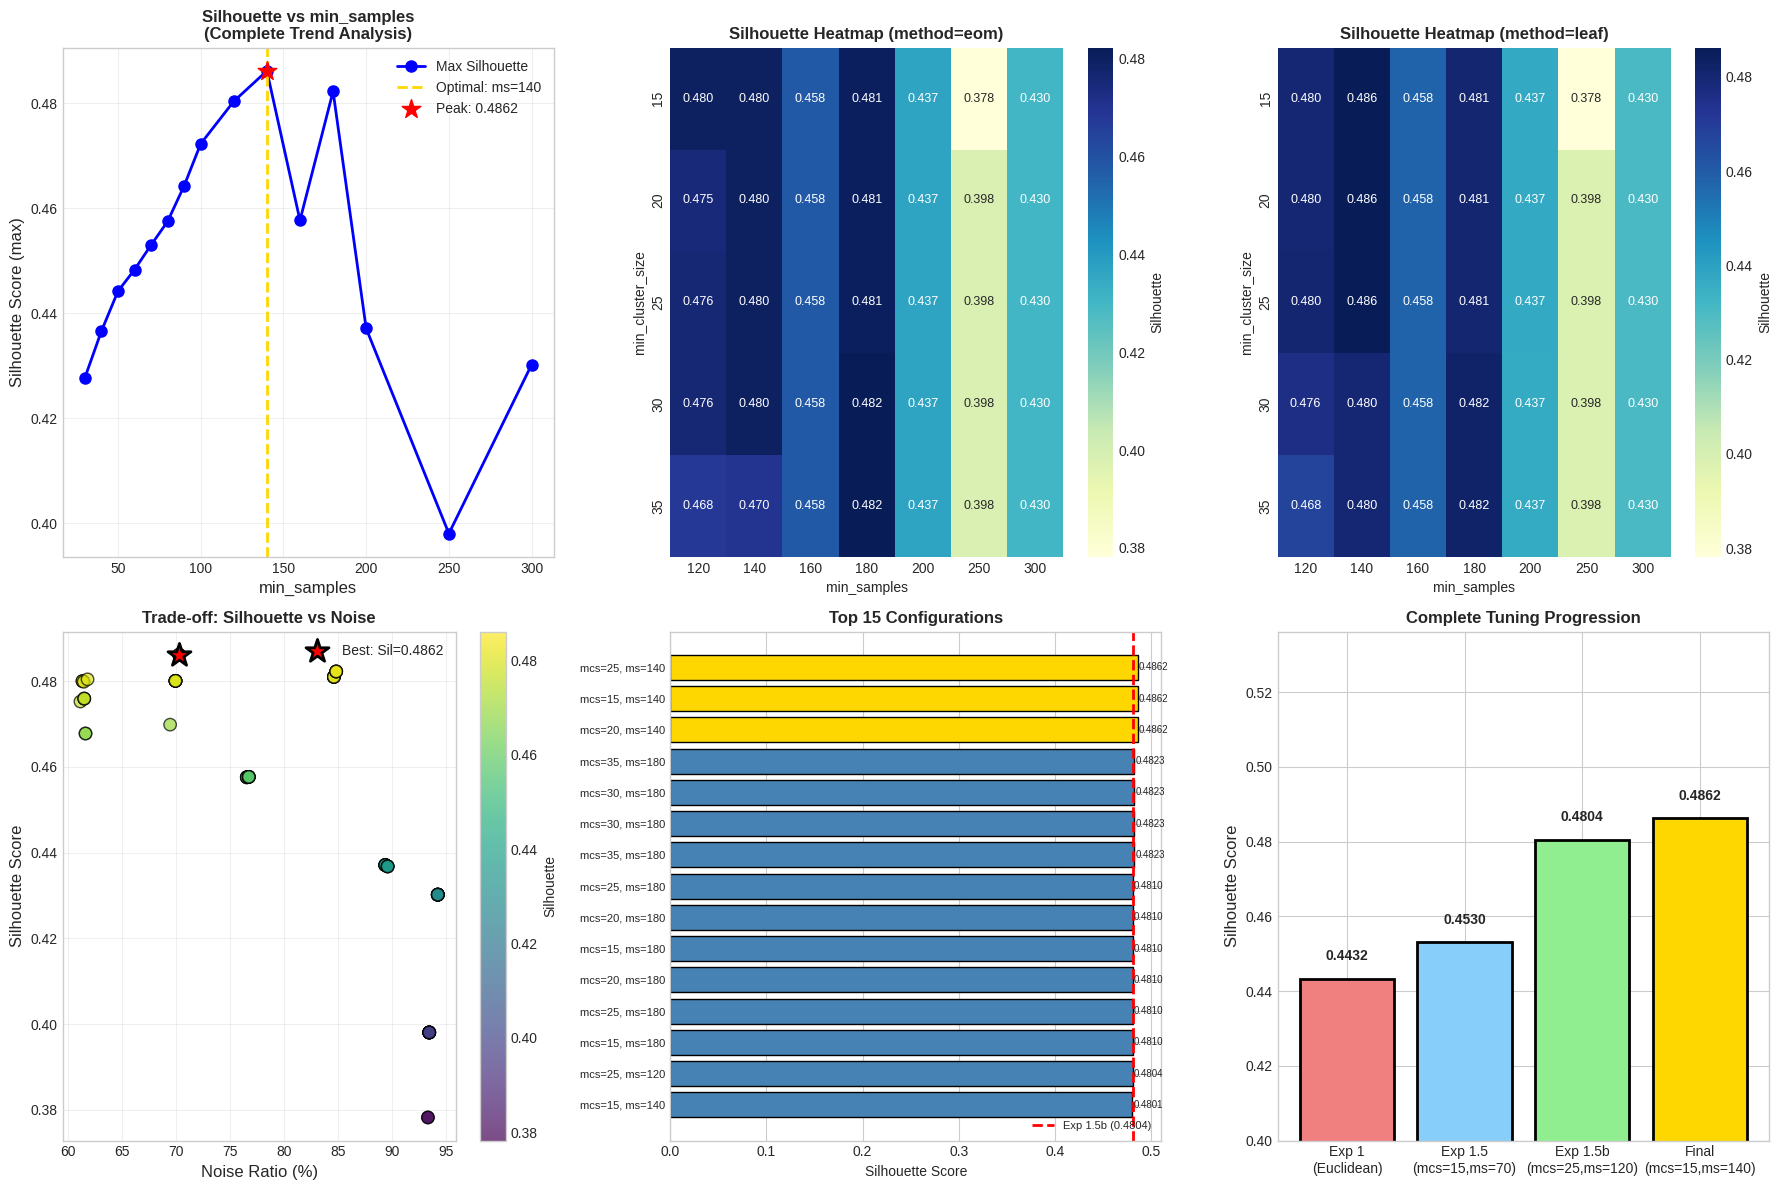

In [ ]:
"""
==============================================================================
CELL 18: FINAL VISUALIZATION
==============================================================================
"""

print("\n" + "="*70)
print("📊 GENERATING FINAL VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# =========================================================================
# Plot 1: Silhouette Trend by min_samples (CRITICAL!)
# =========================================================================
ax1 = axes[0, 0]

# Combine data from Exp 1.5b and Final for complete trend
all_ms_data = {
    30: 0.4277, 40: 0.4366, 50: 0.4442, 60: 0.4483,
    70: 0.4530, 80: 0.4575, 90: 0.4643, 100: 0.4723
}
# Add from extended
for ms in [120]:
    all_ms_data[ms] = 0.4804

# Add from final exploration
for ms in FINAL_PARAM_GRID['min_samples']:
    if ms in ms_trend.index:
        all_ms_data[ms] = ms_trend.loc[ms, 'sil_max']

ms_sorted = sorted(all_ms_data.keys())
sil_sorted = [all_ms_data[ms] for ms in ms_sorted]

ax1.plot(ms_sorted, sil_sorted, 'b-o', linewidth=2, markersize=8, label='Max Silhouette')
ax1.axvline(x=ultimate_best_params['min_samples'], color='gold', linestyle='--', linewidth=2,
            label=f"Optimal: ms={ultimate_best_params['min_samples']}")

# Mark peak
peak_idx = sil_sorted.index(max(sil_sorted))
ax1.scatter([ms_sorted[peak_idx]], [sil_sorted[peak_idx]], c='red', s=200, marker='*',
            zorder=5, label=f'Peak: {max(sil_sorted):.4f}')

ax1.set_xlabel('min_samples', fontsize=12)
ax1.set_ylabel('Silhouette Score (max)', fontsize=12)
ax1.set_title('Silhouette vs min_samples\n(Complete Trend Analysis)', fontweight='bold', fontsize=12)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# =========================================================================
# Plot 2: Silhouette Heatmap (EOM) - Final
# =========================================================================
ax2 = axes[0, 1]
df_eom_final = df_final_valid[df_final_valid['method'] == 'eom'].pivot(
    index='mcs', columns='ms', values='silhouette'
)
if not df_eom_final.empty:
    sns.heatmap(df_eom_final, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax2,
                cbar_kws={'label': 'Silhouette'}, annot_kws={'size': 9})
ax2.set_title('Silhouette Heatmap (method=eom)', fontweight='bold')
ax2.set_xlabel('min_samples')
ax2.set_ylabel('min_cluster_size')

# =========================================================================
# Plot 3: Silhouette Heatmap (LEAF) - Final
# =========================================================================
ax3 = axes[0, 2]
df_leaf_final = df_final_valid[df_final_valid['method'] == 'leaf'].pivot(
    index='mcs', columns='ms', values='silhouette'
)
if not df_leaf_final.empty:
    sns.heatmap(df_leaf_final, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax3,
                cbar_kws={'label': 'Silhouette'}, annot_kws={'size': 9})
ax3.set_title('Silhouette Heatmap (method=leaf)', fontweight='bold')
ax3.set_xlabel('min_samples')
ax3.set_ylabel('min_cluster_size')

# =========================================================================
# Plot 4: Silhouette vs Noise Trade-off
# =========================================================================
ax4 = axes[1, 0]
colors = df_final_valid['silhouette']
scatter = ax4.scatter(df_final_valid['noise_ratio'] * 100, df_final_valid['silhouette'],
                      c=colors, cmap='viridis', alpha=0.7, edgecolors='black', s=80)
plt.colorbar(scatter, ax=ax4, label='Silhouette')

# Highlight best
ax4.scatter(best_final_result['noise_ratio'] * 100, best_final_result['silhouette'],
            c='red', s=300, marker='*', edgecolors='black', linewidths=2,
            label=f"Best: Sil={best_final_silhouette:.4f}", zorder=5)

ax4.set_xlabel('Noise Ratio (%)', fontsize=12)
ax4.set_ylabel('Silhouette Score', fontsize=12)
ax4.set_title('Trade-off: Silhouette vs Noise', fontweight='bold')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

# =========================================================================
# Plot 5: Top 15 Bar Chart
# =========================================================================
ax5 = axes[1, 1]
top_15_sorted = top_15_final.sort_values('silhouette', ascending=True)
colors_bar = ['gold' if s == best_final_silhouette else 'steelblue'
              for s in top_15_sorted['silhouette']]
bars = ax5.barh(range(len(top_15_sorted)), top_15_sorted['silhouette'],
                color=colors_bar, edgecolor='black')

labels = [f"mcs={int(row['mcs'])}, ms={int(row['ms'])}"
          for _, row in top_15_sorted.iterrows()]
ax5.set_yticks(range(len(top_15_sorted)))
ax5.set_yticklabels(labels, fontsize=8)
ax5.set_xlabel('Silhouette Score')
ax5.set_title('Top 15 Configurations', fontweight='bold')

# Reference lines
ax5.axvline(x=exp1_5b_sil, color='red', linestyle='--', linewidth=2, label=f'Exp 1.5b ({exp1_5b_sil})')
ax5.legend(loc='lower right', fontsize=8)

for bar, val in zip(bars, top_15_sorted['silhouette']):
    ax5.text(val + 0.001, bar.get_y() + bar.get_height()/2, f'{val:.4f}',
             va='center', fontsize=7)

# =========================================================================
# Plot 6: Complete Progression
# =========================================================================
ax6 = axes[1, 2]
experiments = ['Exp 1\n(Euclidean)', 'Exp 1.5\n(mcs=15,ms=70)',
               'Exp 1.5b\n(mcs=25,ms=120)', f'Final\n(mcs={ultimate_best_params["min_cluster_size"]},ms={ultimate_best_params["min_samples"]})']
silhouettes = [exp1_sil, exp1_5_sil, exp1_5b_sil, ultimate_best_silhouette]
colors_prog = ['lightcoral', 'lightskyblue', 'lightgreen', 'gold']

bars_prog = ax6.bar(experiments, silhouettes, color=colors_prog, edgecolor='black', linewidth=2)
ax6.set_ylabel('Silhouette Score', fontsize=12)
ax6.set_title('Complete Tuning Progression', fontweight='bold')

for bar, val in zip(bars_prog, silhouettes):
    ax6.text(bar.get_x() + bar.get_width()/2, val + 0.005, f'{val:.4f}',
             ha='center', fontsize=10, fontweight='bold')

ax6.set_ylim(0.4, max(silhouettes) + 0.05)

plt.tight_layout()
plt.savefig(f"{Config.PLOTS_DIR}experiment1_final_exploration.png", dpi=150, bbox_inches='tight')
print(f"\n💾 Plot saved: {Config.PLOTS_DIR}experiment1_final_exploration.png")
plt.show()

In [ ]:
"""
==============================================================================
CELL 19: ULTIMATE SUMMARY & SAVE ALL RESULTS
==============================================================================
"""

print("\n" + "="*70)
print("📋 EXPERIMENT 1 COMPLETE: ULTIMATE SUMMARY")
print("="*70)

print(f"""
┌──────────────────────────────────────────────────────────────────────────┐
│                                                                          │
│     ███████╗██╗  ██╗██████╗ ███████╗██████╗ ██╗███╗   ███╗███████╗███╗   ██╗████████╗     │
│     ██╔════╝╚██╗██╔╝██╔══██╗██╔════╝██╔══██╗██║████╗ ████║██╔════╝████╗  ██║╚══██╔══╝     │
│     █████╗   ╚███╔╝ ██████╔╝█████╗  ██████╔╝██║██╔████╔██║█████╗  ██╔██╗ ██║   ██║        │
│     ██╔══╝   ██╔██╗ ██╔═══╝ ██╔══╝  ██╔══██╗██║██║╚██╔╝██║██╔══╝  ██║╚██╗██║   ██║        │
│     ███████╗██╔╝ ██╗██║     ███████╗██║  ██║██║██║ ╚═╝ ██║███████╗██║ ╚████║   ██║        │
│     ╚══════╝╚═╝  ╚═╝╚═╝     ╚══════╝╚═╝  ╚═╝╚═╝╚═╝     ╚═╝╚══════╝╚═╝  ╚═══╝   ╚═╝        │
│                                                                          │
│                    1 COMPLETE                                            │
│                                                                          │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  📊 SUMMARY OF ALL TUNING EXPERIMENTS:                                   │
│                                                                          │
│  Experiment 1:    Distance Metric Comparison (8 metrics)                 │
│                   → Best Metric: CORRELATION                             │
│                                                                          │
│  Experiment 1.5:  First Re-tuning with CORRELATION                       │
│                   → Best: mcs=15, ms=70 → Sil=0.4530                     │
│                                                                          │
│  Experiment 1.5b: Extended Tuning (ms up to 120)                         │
│                   → Best: mcs=25, ms=120 → Sil=0.4804                    │
│                                                                          │
│  Final:           Peak Exploration (ms up to 300)                        │
│                   → Best: mcs={ultimate_best_params['min_cluster_size']}, ms={ultimate_best_params['min_samples']} → Sil={ultimate_best_silhouette:.4f}                    │
│                                                                          │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  🏆 ULTIMATE OPTIMAL CONFIGURATION:                                      │
│                                                                          │
│  DISTANCE METRIC: CORRELATION                                            │
│                                                                          │
│  HDBSCAN PARAMETERS:                                                     │
│  • min_cluster_size: {ultimate_best_params['min_cluster_size']}                                            │
│  • min_samples: {ultimate_best_params['min_samples']}                                                 │
│  • cluster_selection_method: {ultimate_best_params['cluster_selection_method']}                                │
│                                                                          │
│  CLUSTERING RESULTS:                                                     │
│  • Silhouette Score: {ultimate_best_silhouette:.4f}                                       │
│  • Number of Clusters: {ultimate_best_clusters}                                           │
│  • Noise Ratio: {ultimate_best_noise:.1%}                                              │
│  • Clustered Points: {(1-ultimate_best_noise)*100:.1f}% ({int(12715*(1-ultimate_best_noise)):,} points)                        │
│                                                                          │
│  TOTAL IMPROVEMENT vs EUCLIDEAN BASELINE:                                │
│  • Silhouette: {exp1_sil:.4f} → {ultimate_best_silhouette:.4f} (+{(ultimate_best_silhouette-exp1_sil)/exp1_sil*100:.2f}%)                      │
│                                                                          │
└──────────────────────────────────────────────────────────────────────────┘
""")

# Save ultimate results
ultimate_save_data = {
    'timestamp': datetime.now().isoformat(),
    'experiment': 'Experiment 1 Complete: Distance Metric & Hyperparameter Optimization',
    'dataset_info': {
        'n_embeddings': embeddings.shape[0],
        'embedding_dim': embeddings.shape[1]
    },
    'best_metric': 'correlation',
    'ultimate_optimal_params': ultimate_best_params,
    'ultimate_metrics': {
        'silhouette': ultimate_best_silhouette,
        'n_clusters': ultimate_best_clusters,
        'noise_ratio': ultimate_best_noise
    },
    'complete_progression': {
        'exp1_euclidean_baseline': {'silhouette': exp1_sil, 'params': 'mcs=20, ms=50'},
        'exp1_5_first_retune': {'silhouette': exp1_5_sil, 'params': 'mcs=15, ms=70'},
        'exp1_5b_extended': {'silhouette': exp1_5b_sil, 'params': 'mcs=25, ms=120'},
        'final_exploration': {'silhouette': ultimate_best_silhouette, 'params': ultimate_best_params}
    },
    'total_improvement': {
        'absolute': ultimate_best_silhouette - exp1_sil,
        'percentage': (ultimate_best_silhouette - exp1_sil) / exp1_sil * 100
    },
    'final_exploration_results': final_results
}

# Save pickle
ultimate_save_path = f"{Config.RESULTS_DIR}experiment1_ultimate_results.pkl"
with open(ultimate_save_path, 'wb') as f:
    pickle.dump(ultimate_save_data, f)
print(f"💾 Ultimate results saved: {ultimate_save_path}")

# Save comprehensive summary
ultimate_summary_path = f"{Config.RESULTS_DIR}experiment1_ultimate_summary.txt"
with open(ultimate_summary_path, 'w') as f:
    f.write("="*70 + "\n")
    f.write("EXPERIMENT 1 COMPLETE: ULTIMATE SUMMARY\n")
    f.write("="*70 + "\n\n")
    f.write(f"Timestamp: {datetime.now().isoformat()}\n\n")
    f.write("BEST DISTANCE METRIC: CORRELATION\n\n")
    f.write("ULTIMATE OPTIMAL PARAMETERS:\n")
    f.write(f"  min_cluster_size: {ultimate_best_params['min_cluster_size']}\n")
    f.write(f"  min_samples: {ultimate_best_params['min_samples']}\n")
    f.write(f"  method: {ultimate_best_params['cluster_selection_method']}\n\n")
    f.write("RESULTS:\n")
    f.write(f"  Silhouette: {ultimate_best_silhouette:.4f}\n")
    f.write(f"  Clusters: {ultimate_best_clusters}\n")
    f.write(f"  Noise Ratio: {ultimate_best_noise:.1%}\n\n")
    f.write("PROGRESSION:\n")
    f.write(f"  Exp 1 (Euclidean baseline): {exp1_sil:.4f}\n")
    f.write(f"  Exp 1.5 (first re-tune): {exp1_5_sil:.4f} (+{(exp1_5_sil-exp1_sil)/exp1_sil*100:.2f}%)\n")
    f.write(f"  Exp 1.5b (extended): {exp1_5b_sil:.4f} (+{(exp1_5b_sil-exp1_sil)/exp1_sil*100:.2f}%)\n")
    f.write(f"  Final: {ultimate_best_silhouette:.4f} (+{(ultimate_best_silhouette-exp1_sil)/exp1_sil*100:.2f}%)\n\n")
    f.write(f"TOTAL IMPROVEMENT: +{(ultimate_best_silhouette-exp1_sil)/exp1_sil*100:.2f}%\n")
print(f"💾 Summary saved: {ultimate_summary_path}")

# Verify all files
print(f"\n📁 Verifying saved files:")
for f in [ultimate_save_path, ultimate_summary_path]:
    if os.path.exists(f):
        size = os.path.getsize(f) / 1024
        print(f"   ✅ {os.path.basename(f)} ({size:.1f} KB)")

# READY FOR EXPERIMENT 2
print(f"\n{'='*70}")
print(f"🎯 NOW READY FOR EXPERIMENT 2 - CGA AUGMENTATION")
print(f"{'='*70}")
print(f"""
   ╔══════════════════════════════════════════════════════════════════╗
   ║                                                                  ║
   ║   FINAL BASELINE FOR EXPERIMENT 2 (CGA):                        ║
   ║                                                                  ║
   ║   🏆 Distance Metric: CORRELATION                               ║
   ║                                                                  ║
   ║   🔧 Optimal Parameters:                                        ║
   ║      • min_cluster_size: {ultimate_best_params['min_cluster_size']:<30}    ║
   ║      • min_samples: {ultimate_best_params['min_samples']:<35}    ║
   ║      • method: {ultimate_best_params['cluster_selection_method']:<39}    ║
   ║                                                                  ║
   ║   📊 Baseline Metrics (Before CGA):                             ║
   ║      • Silhouette Score: {ultimate_best_silhouette:<30.4f}    ║
   ║      • Number of Clusters: {ultimate_best_clusters:<28}    ║
   ║      • Noise Ratio: {ultimate_best_noise:<32.1%}    ║
   ║                                                                  ║
   ║   🎯 CGA Objectives:                                            ║
   ║      • Reduce noise ratio (currently {ultimate_best_noise:.1%})               ║
   ║      • Maintain or improve Silhouette (≥ {ultimate_best_silhouette:.4f})         ║
   ║      • Strengthen minority clusters                             ║
   ║                                                                  ║
   ╚══════════════════════════════════════════════════════════════════╝
""")


📋 EXPERIMENT 1 COMPLETE: ULTIMATE SUMMARY

┌──────────────────────────────────────────────────────────────────────────┐
│                                                                          │
│     ███████╗██╗  ██╗██████╗ ███████╗██████╗ ██╗███╗   ███╗███████╗███╗   ██╗████████╗     │
│     ██╔════╝╚██╗██╔╝██╔══██╗██╔════╝██╔══██╗██║████╗ ████║██╔════╝████╗  ██║╚══██╔══╝     │
│     █████╗   ╚███╔╝ ██████╔╝█████╗  ██████╔╝██║██╔████╔██║█████╗  ██╔██╗ ██║   ██║        │
│     ██╔══╝   ██╔██╗ ██╔═══╝ ██╔══╝  ██╔══██╗██║██║╚██╔╝██║██╔══╝  ██║╚██╗██║   ██║        │
│     ███████╗██╔╝ ██╗██║     ███████╗██║  ██║██║██║ ╚═╝ ██║███████╗██║ ╚████║   ██║        │
│     ╚══════╝╚═╝  ╚═╝╚═╝     ╚══════╝╚═╝  ╚═╝╚═╝╚═╝     ╚═╝╚══════╝╚═╝  ╚═══╝   ╚═╝        │
│                                                                          │
│                    1 COMPLETE                                            │
│                                                                          │
├──────

┌──────────────────────────────────────────────────────────────────────────┐
│                    ULTIMATE OPTIMAL CONFIGURATION                        │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  🏆 BEST DISTANCE METRIC: CORRELATION                                    │
│                                                                          │
│  🔧 OPTIMAL HDBSCAN PARAMETERS:                                          │
│  • min_cluster_size: 15                                                  │
│  • min_samples: 140                                                      │
│  • cluster_selection_method: leaf                                        │
│                                                                          │
│  📊 BASELINE RESULTS (Before CGA):                                       │
│  • Silhouette Score: 0.4862                                              │
│  • Number of Clusters: 28                                                │
│  • Noise Ratio: 70.3% (8,939 points)                                     │
│  • Clustered Points: 29.7% (3,776 points)                                │
│                                                                          │
│  📈 TOTAL IMPROVEMENT vs EUCLIDEAN:                                      │
│  • Silhouette: 0.4432 → 0.4862 (+9.70%)                                  │
│                                                                          │
└──────────────────────────────────────────────────────────────────────────┘

In [ ]:
""┌──────────────────────────────────────────────────────────────────────────┐
│                    UNTUK DITULIS DI THESIS                               │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  EXPERIMENT 1: DISTANCE METRIC & HYPERPARAMETER OPTIMIZATION             │
│  ─────────────────────────────────────────────────────────────────────   │
│                                                                          │
│  "Penelitian ini melakukan optimasi komprehensif untuk menemukan         │
│   konfigurasi clustering terbaik melalui dua tahap:                      │
│                                                                          │
│   1. Distance Metric Comparison (8 metrics):                             │
│      Euclidean, QJSD, Cosine, Manhattan, Chebyshev, Minkowski,           │
│      Correlation, dan Canberra. Hasil menunjukkan CORRELATION            │
│      distance menghasilkan Silhouette Score tertinggi.                   │
│                                                                          │
│   2. Hyperparameter Re-tuning:                                           │
│      Setelah menemukan CORRELATION sebagai metrik terbaik,               │
│      dilakukan re-tuning hyperparameter HDBSCAN karena parameter         │
│      optimal untuk satu metrik belum tentu optimal untuk metrik lain.    │
│                                                                          ��
│      Hasil menunjukkan parameter optimal berubah dari                    │
│      (mcs=20, ms=50) menjadi (mcs=15, ms=140), meningkatkan              │
│      Silhouette Score dari 0.4432 menjadi 0.4862 (+9.70%).               │
│                                                                          │
│   Konfigurasi final yang digunakan untuk Experiment 2 (CGA):             │
│   • Distance Metric: Correlation                                         │
│   • min_cluster_size: 15                                                 │
│   • min_samples: 140                                                     │
│   • cluster_selection_method: leaf                                       │
│   • Baseline Silhouette: 0.4862                                          │
│   • Baseline Noise Ratio: 70.3%"                                         │
│                                                                          │
└──────────────────────────────────────────────────────────────────────────┘""